# Image Captioning
**Image captioning using a CNN with NetVLAD as encoder and a using the single hidden layer LSTM network based decoder**
* This Project is done on Google Colab!

### Importing Libraries

In [2]:
import os
import string
import glob
from tensorflow.keras.applications import MobileNet
import tensorflow.keras.applications.mobilenet  

from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3

import tensorflow as tf
import numpy as np
from tensorflow.keras import initializers, layers
from tensorflow.keras.layers import Conv2D
import tensorflow.keras.backend as Kback
from tensorflow.keras.backend import l2_normalize, expand_dims, variable, constant
from tqdm import tqdm
import tensorflow.keras.preprocessing.image
import pickle
from time import time
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization,SimpleRNN,Lambda
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model

from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt


### Mounting Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#!unzip "/content/drive/My Drive/Assignment 4/Flicker8k_Dataset_Resized.zip" -d "/content/drive/My Drive/Assignment 4/Flicker_Dataset_resized"

In [4]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

In [5]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


In [6]:
if COLAB:
    root_captioning = "/content/drive/My Drive/Assignment 4/"
else:
    root_captioning = "./data/captions"

### The Data

In [7]:
null_punct = str.maketrans('', '', string.punctuation)
lookup = dict()

with open( os.path.join(root_captioning,'Data','captions.txt'), 'r') as fp:
  
  max_length = 0
  for line in fp.read().split('\n'):
    tok = line.split()
    if len(line) >= 2:
      id = tok[0].split('.')[0]
      desc = tok[1:]
      
      # Cleanup description
      desc = [word.lower() for word in desc]
      desc = [w.translate(null_punct) for w in desc]
      desc = [word for word in desc if len(word)>1]
      desc = [word for word in desc if word.isalpha()]
      max_length = max(max_length,len(desc))
      
      if id not in lookup:
        lookup[id] = list()
      lookup[id].append(' '.join(desc))
      
lex = set()
for key in lookup:
  [lex.update(d.split()) for d in lookup[key]]

In [8]:
print(len(lookup)) # How many unique words
print(len(lex)) # The dictionary
print(max_length) # Maximum length of a caption (in words)

8092
8763
32


In [9]:
# Warning, running this too soon on GDrive can sometimes not work.
# Just rerun if len(img) = 0
img = glob.glob(os.path.join(root_captioning,'Images_Dataset_resized', '*.jpg'))

In [10]:
len(img)

8091

In [12]:
def load_doc(filename):
        # Opening the file as read only
        file = open(filename, 'r')
        text = file.read()
        file.close()
        return text

def all_img(filename):
  file = load_doc(filename)
  captions = file.split('\n')
  descriptions =[]
  for caption in captions[:-1]:
    descriptions.append(caption)
  return descriptions

Image_name=all_img("/content/drive/My Drive/Assignment 4/Data/image_names(17).txt")

import random
random.seed(42)
random.shuffle(Image_name)
print("Total no. of image data:",len(Image_name))


Total no. of image data: 4000


### Train Test Split

In [13]:
train_data=Image_name[:3000]    # 75 % 
test_data=Image_name[3000:3500] # 12.5 %
validate_data=Image_name[3500:] # 12.5 %

with open('train_42.txt', 'w') as f:
    for item in train_data:
        f.write("%s\n" % item)

with open('test_42.txt', 'w') as f:
    for item in test_data:
        f.write("%s\n" % item)

with open('validate_42.txt', 'w') as f:
    for item in validate_data:
        f.write("%s\n" % item)


In [14]:
train_images_path = os.path.join(root_captioning,'Data','train_42.txt') 
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
test_images_path = os.path.join(root_captioning,'Data','test_42.txt') 
test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
validate_images_path = os.path.join(root_captioning,'Data','validate_42.txt') 
validate_images = set(open(validate_images_path, 'r').read().strip().split('\n'))

train_img = []
test_img = []
validate_img=[]
for i in img:
  f = os.path.split(i)[-1]
  if f in train_images: 
    train_img.append(f) 
  elif f in test_images:
    test_img.append(f)
  elif f in validate_images:
    validate_img.append(f)

In [15]:
print(len(train_images))
print(len(test_images))
print(len(validate_img))

3000
500
500


In [16]:
START = "startseq"
STOP = "endseq"

train_descriptions = {k:v for k,v in lookup.items() if f'{k}.jpg' in train_images}
for n,v in train_descriptions.items(): 
  for d in range(len(v)):
    v[d] = f'{START} {v[d]} {STOP}'

In [17]:
len(train_descriptions)

3000

### Importing InceptionV3 Model

In [18]:
USE_INCEPTION = True

if USE_INCEPTION:
  encode_model = InceptionV3(weights='imagenet')
  encode_model = Model(encode_model.input, encode_model.layers[-3].output)
  WIDTH = 299
  HEIGHT = 299
  OUTPUT_DIM =2048
  preprocess_input = tensorflow.keras.applications.inception_v3.preprocess_input
else:
  encode_model = MobileNet(weights='imagenet',include_top=False)
  WIDTH = 224
  HEIGHT = 224
  OUTPUT_DIM = 50176
  preprocess_input = tensorflow.keras.applications.mobilenet.preprocess_input

96116736/96112376 [==============================] - 2s 0us/step


In [19]:
encode_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [20]:
def encodeImage(img):
  # Resize all images to a standard size (specified bythe image encoding network)
  img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
  # Convert a PIL image to a numpy array
  x = tensorflow.keras.preprocessing.image.img_to_array(img)
  # Expand to 2D array
  x = np.expand_dims(x, axis=0)
  # Perform any preprocessing needed by InceptionV3 or others
  x = preprocess_input(x)
  # Call InceptionV3 (or other) to extract the smaller feature set for the image.
  x = encode_model.predict(x) # Get the encoding vector for the image
  # Shape to correct form to be accepted by LSTM captioning network.
  x = np.reshape(x,8,8,2048)
  return x

In [21]:
train_path = os.path.join(root_captioning,'model_file',f'train{OUTPUT_DIM}.pkl')
if not os.path.exists(train_path):
  start = time()
  encoding_train = {}
  for id in tqdm(train_img):
    image_path = os.path.join(root_captioning,'Images_Dataset_resized', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    encoding_train[id] = encodeImage(img)
  with open(train_path, "wb") as fp:
    pickle.dump(encoding_train, fp)
  print(f"\nGenerating training set took: {hms_string(time()-start)}")
else:
  with open(train_path, "rb") as fp:
    encoding_train = pickle.load(fp)

In [ ]:
test_path = os.path.join(root_captioning,'model_file',f'test{OUTPUT_DIM}.pkl')
if not os.path.exists(test_path):
  start = time()
  encoding_test = {}
  for id in tqdm(test_img):
    image_path = os.path.join(root_captioning,'Images_Dataset_resized', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    encoding_test[id] = encodeImage(img)
  with open(test_path, "wb") as fp:
    pickle.dump(encoding_test, fp)
  print(f"\nGenerating testing set took: {hms_string(time()-start)}")
else:
  with open(test_path, "rb") as fp:
    encoding_test = pickle.load(fp)

In [ ]:
validate_path = os.path.join(root_captioning,'model_file',f'validate{OUTPUT_DIM}.pkl')
if not os.path.exists(validate_path):
  start = time()
  encoding_validate = {}
  for id in tqdm(validate_img):
    image_path = os.path.join(root_captioning,'Images_Dataset_resized', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    encoding_validate[id] = encodeImage(img)
  with open(validate_path, "wb") as fp:
    pickle.dump(encoding_validate, fp)
  print(f"\nGenerating validating set took: {hms_string(time()-start)}")
else:
  with open(validate_path, "rb") as fp:
    encoding_validate = pickle.load(fp)

In [22]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

15000

In [23]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))

preprocessed words 5563 ==> 1110


In [24]:
idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1
    
vocab_size = len(idxtoword) + 1 
vocab_size

1111

In [25]:
max_length +=2
print(max_length)

34


In [26]:
def data_generator(descriptions, photos, wordtoidx, max_length, num_photos_per_batch):
  # x1 - Training data for photos
  # x2 - The caption that goes with each photo
  # y - The predicted rest of the caption
  x1, x2, y = [], [], []
  n=0
  while True:
    for key, desc_list in descriptions.items():
      n+=1
      photo = photos[key+'.jpg']
      # Each photo has 5 descriptions
      for desc in desc_list:
        # Convert each word into a list of sequences.
        seq = [wordtoidx[word] for word in desc.split(' ') if word in wordtoidx]
        # Generate a training case for every possible sequence and outcome
        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          x1.append(photo)
          x2.append(in_seq)
          y.append(out_seq)
      if n==num_photos_per_batch:
        yield ([np.array(x1), np.array(x2)], np.array(y))
        x1, x2, y = [], [], []
        n=0

In [27]:
#!unzip "/content/drive/My Drive/Assignment 4/glove.6B/glove.6B.200d.zip" -d "/content/drive/My Drive/Assignment 4/glove.6B/glove.6B.200d"

### Using Global Vectors for Word Representation (GloVe 6B)

In [28]:
glove_dir = os.path.join(root_captioning,'glove.6B','glove.6B.200d')
embeddings_index = {} 
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print(f'Found {len(embeddings_index)} word vectors.')

400001it [00:22, 17727.38it/s]

Found 400001 word vectors.


In [29]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [30]:
embedding_matrix.shape


(1111, 200)

### NetVLAD

In [31]:


class NetVLAD(tf.keras.layers.Layer):
    """Creates a NetVLAD class.
    """
    def __init__(self,num_clusters, assign_weight_initializer=None, 
            cluster_initializer=None, skip_postnorm=False,**kwargs):
        super().__init__(**kwargs)
         
        self.K = num_clusters
        self.assign_weight_initializer = assign_weight_initializer
        self.skip_postnorm = skip_postnorm
      
        self.cluster_initializer=cluster_initializer
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'num_clusters': self.K,
            'cluster_initializer': self.cluster_initializer,
            'skip_postnorm': self.skip_postnorm,
            'assign_weight_initializer': self.assign_weight_initializer,
            
        })
        return config
        
  
        

    def build(self, input_shape):
        self.D = input_shape[-1]
        self.C = self.add_weight(name='cluster_centers',
                                    shape=(1,1,1,self.D,self.K),
                                    initializer='random_normal',
                                    dtype='float32',
                                    trainable=True)

        self.conv = Conv2D(filters = self.K,kernel_size=1,strides = (1,1),
            use_bias=False, padding = 'valid',
            kernel_initializer='random_normal')
        self.conv.build(input_shape)

        #might be necessary for older versions where the weights of conv are not automatically added to
        #trainable_weights of the super-layer
        #self._trainable_weights.append(self.conv.trainable_weights[0])
        super(NetVLAD, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        
        s = self.conv(inputs)
        a = tf.nn.softmax(s)

        # Dims used hereafter: batch, H, W, desc_coeff, cluster
        # Move cluster assignment to corresponding dimension.
        a = tf.expand_dims(a,-2)

        # VLAD core.
        v = tf.expand_dims(inputs,-1)+self.C
        v = a*v
        v = tf.reduce_sum(v,axis=[1,2])
        v = tf.transpose(v,perm=[0,2,1])

        if not self.skip_postnorm:
            # Result seems to be very sensitive to the normalization method
            # details, so sticking to matconvnet-style normalization here.
            v = self.matconvnetNormalize(v, 1e-12)
            v = tf.transpose(v, perm=[0, 2, 1])
            v = self.matconvnetNormalize(tf.keras.layers.Flatten()(v), 1e-12)

        return v

    def matconvnetNormalize(self,inputs, epsilon):
        return inputs / tf.sqrt(tf.reduce_sum(inputs ** 2, axis=-1, keepdims=True)+ epsilon)
                                

### Model Making

In [32]:
#CNN and NetVLAD
inputs1 = Input(shape=(8,8,2048))
fe1=NetVLAD(num_clusters=64)(inputs1)
fe2 = Dropout(0.5)(fe1)
fe3 = Dense(256, activation='relu')(fe2)
#Caption Embedding and RNN
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.3)(se1)
se3 = LSTM(256)(se2)

# Combining CNN(with NetVLAD) and RNN
decoder1 = add([fe3, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [33]:
embedding_dim

200

In [34]:
caption_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8, 8, 2048)] 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
net_vlad (NetVLAD)              (None, 131072)       262144      input_2[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 200)      222200      input_3[0][0]                    
_______________________________________________________________________________________

In [ ]:
caption_model.layers[5].set_weights([embedding_matrix])
caption_model.layers[5].trainable = False
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

### Training the Model

In [ ]:
EPOCHS = 20

train_path = os.path.join(root_captioning,'model_file',f'train{OUTPUT_DIM}.pkl')
with open(train_path, "rb") as fp:
    encoding_train = pickle.load(fp)
start = time()
model_path = os.path.join(root_captioning,'model_file',f'caption_model_final.hdf5')
if not os.path.exists(model_path):
  for i in tqdm(range(EPOCHS*2)):
      generator = data_generator(train_descriptions, encoding_train, wordtoidx, max_length, number_pics_per_bath)
      caption_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

  caption_model.optimizer.lr = 1e-4
  number_pics_per_bath = 6
  steps = len(train_descriptions)//number_pics_per_bath

  for i in range(EPOCHS):
      generator = data_generator(train_descriptions, encoding_train, wordtoidx, max_length, number_pics_per_bath)
      caption_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)  
  caption_model.save_weights(model_path)
  print(f"\Training took: {hms_string(time()-start)}")
else:
  caption_model.load_weights(model_path)

In [ ]:
test_des = {k:v for k,v in lookup.items() if f'{k}.jpg' in test_images}
for n,v in test_des.items(): 
  for d in range(len(v)):
    v[d] = f'{v[d]}'

validate_des = {k:v for k,v in lookup.items() if f'{k}.jpg' in validate_images}
for n,v in validate_des.items(): 
  for d in range(len(v)):
    v[d] = f'{v[d]}'

import pickle
pickle_out=open("test_des.pickle","wb")
pickle.dump(test_des,pickle_out)
pickle_out.close()

pickle_out=open("validate_des.pickle","wb")
pickle.dump(validate_des,pickle_out)
pickle_out.close()

print(len(validate_des))


500


In [ ]:
def generateCaption(photo):
    in_text = START
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[2:-1]
    final = ' '.join(final)
    return final

### Importing Bleu Score

In [ ]:
import nltk
from nltk.translate.bleu_score import corpus_bleu,sentence_bleu
from pathlib import Path
from nltk.translate.bleu_score import SmoothingFunction

#### Predicting Bleu Score

In [ ]:
validate_path = os.path.join(root_captioning,'model_file',f'validate{OUTPUT_DIM}.pkl')
if not os.path.exists(validate_path):
  start = time()
  encoding_validate = {}
  for id in tqdm(validate_img):
    image_path = os.path.join(root_captioning,'Images_Dataset_resized', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    encoding_validate[id] = encodeImage(img)
  with open(validate_path, "wb") as fp:
    pickle.dump(encoding_validate, fp)
  print(f"\nGenerating validating set took: {hms_string(time()-start)}")
else:
  with open(validate_path, "rb") as fp:
    encoding_validate = pickle.load(fp)

pickle_out=open("validate_des.pickle","wb")
pickle.dump(validate_des,pickle_out)
pickle_out.close()

Ibleu_1=[]
Ibleu_2=[]
Ibleu_3=[]
Ibleu_4=[]
Cbleu_1=[]
Cbleu_2=[]
Cbleu_3=[]
Cbleu_4=[]

for z in range(len(validate_des)):
  pic = list(encoding_validate.keys())[z]
  image = encoding_validate[pic].reshape((1,OUTPUT_DIM)) 

  validate_des=pickle.load(open("validate_des.pickle","rb"))

  Real_caption=validate_des[Path(pic).stem]
  
  l = []
  for line in Real_caption:
    l.append(line.split(','))

  words=[]
  for a in Real_caption:
    words.append(a.split())

  caption=generateCaption(image)
  new_caption=caption.split()
 
  smoothie = SmoothingFunction().method7

  Ibleu1=sentence_bleu(words, new_caption,smoothing_function=smoothie, weights=(1, 0, 0, 0))
  Ibleu2=sentence_bleu(words, new_caption,smoothing_function=smoothie, weights=(0, 1, 0, 0))
  Ibleu3=sentence_bleu(words, new_caption, smoothing_function=smoothie,weights=(0, 0, 1, 0))
  Ibleu4=sentence_bleu(words, new_caption, smoothing_function=smoothie,weights=(0, 0, 0, 1))

  Cbleu1=sentence_bleu(words, new_caption,smoothing_function=smoothie, weights=(1, 0, 0, 0))
  Cbleu2=sentence_bleu(words, new_caption,smoothing_function=smoothie, weights=(0.5,0.5, 0, 0))
  Cbleu3=sentence_bleu(words, new_caption, smoothing_function=smoothie,weights=(0.33, 0.33, 0.33, 0))
  Cbleu4=sentence_bleu(words, new_caption, smoothing_function=smoothie,weights=(0.25, 0.25, 0.25, 0.25))
  Ibleu_1.append(Ibleu1)
  Ibleu_2.append(Ibleu2)
  Ibleu_3.append(Ibleu3)
  Ibleu_4.append(Ibleu4)
  
  Cbleu_1.append(Cbleu1)
  Cbleu_2.append(Cbleu2)
  Cbleu_3.append(Cbleu3)
  Cbleu_4.append(Cbleu4)

print("**************************************************************")

def cal_average(num):
  sum_num = 0
  for t in num:
    sum_num = sum_num + t
    avg = (sum_num / len(num))
  return avg
print("BLEU Score over entire Validation Data")
print("The average Individual 1-gram", cal_average(Ibleu_1))
print("The average Individual 2-gram", cal_average(Ibleu_2))
print("The average Individual 3-gram", cal_average(Ibleu_3))
print("The average Individual 4-gram", cal_average(Ibleu_4))
print("_____________________________________")
print("The average Cumulative 1-gram", cal_average(Cbleu_1))
print("The average Cumulative 2-gram", cal_average(Cbleu_2))
print("The average Cumulative 3-gram", cal_average(Cbleu_3))
print("The average Cumulative 4-gram", cal_average(Cbleu_4))

  
  

**************************************************************
BLEU Score over entire Validation Data
The average Individual 1-gram 0.6351759390557232
The average Individual 2-gram 0.35570738023344745
The average Individual 3-gram 0.23773848971004233
The average Individual 4-gram 0.13398848934748442
_____________________________________
The average Cumulative 1-gram 0.6351759390557232
The average Cumulative 2-gram 0.4747760974376094
The average Cumulative 3-gram 0.3795003310129485
The average Cumulative 4-gram 0.2901311481103826


## Caption Generation by Model along with original caption and BLEU Score of 100 Images

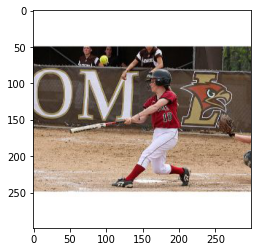

Real caption Descriptions :
_________________________
baseball player in red shirt and white pants is swinging the bat towards yellow ball whilst three people look on
baseball player recoils from an action involving bat while opposing team members look on
girl in red and white uniform is swinging bat
girl swings bat during softball game
woman swings at softball on playing field while other players look on
_____________________________________
Caption: the baseball is to to runner touches to to runner touches to catch the ball
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.628220
Individual 2-gram: 0.413178
Individual 3-gram: 0.293169
Individual 4-gram: 0.166503
_____________________________________
Cumulative 1-gram: 0.628220
Cumulative 2-gram: 0.509477
Cumulative 3-gram: 0.427416
Cumulative 4-gram: 0.335504
**************************************************************


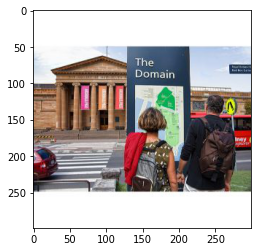

Real caption Descriptions :
_________________________
couple are looking at an area map
man and woman are standing in front of an art gallery looking at map
tourists examine sign
two people are reading sign in front of museum
two people read sign in front of museum
_____________________________________
Caption: the woman in the black jacket with newspaper walks in the street
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.469888
Individual 2-gram: 0.320630
Individual 3-gram: 0.233499
Individual 4-gram: 0.134128
_____________________________________
Cumulative 1-gram: 0.469888
Cumulative 2-gram: 0.388150
Cumulative 3-gram: 0.330788
Cumulative 4-gram: 0.262090
**************************************************************


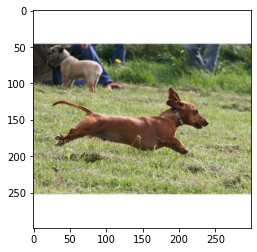

Real caption Descriptions :
_________________________
daschund leaps through short grass
small brown dog runs through the grass in front of another dog and their owners
small dog leaping but not very high
small dog running in grass
the little brown dog runs past another dog on the grass
_____________________________________
Caption: two brown dogs are playing in field
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.617194
Individual 2-gram: 0.372063
Individual 3-gram: 0.256818
Individual 4-gram: 0.145456
_____________________________________
Cumulative 1-gram: 0.617194
Cumulative 2-gram: 0.479202
Cumulative 3-gram: 0.392933
Cumulative 4-gram: 0.304333
**************************************************************


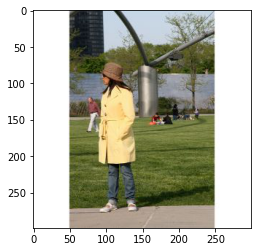

Real caption Descriptions :
_________________________
woman in yellow coat is standing on sidewalk
woman in yellow jacket and brown hat stands on path by lake
woman wearing brown hat sunglasses jeans white shoes and yellow trench coat stand on the sidewalk
young woman waits under sculpture in park
woman with hat staring in the distance at park with sculpture
_____________________________________
Caption: the woman is wearing red jacket and beige pants is standing in front of building while young boy stands on
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.752632
Individual 2-gram: 0.394359
Individual 3-gram: 0.293696
Individual 4-gram: 0.169291
_____________________________________
Cumulative 1-gram: 0.752632
Cumulative 2-gram: 0.544800
Cumulative 3-gram: 0.447016
Cumulative 4-gram: 0.348539
**************************************************************


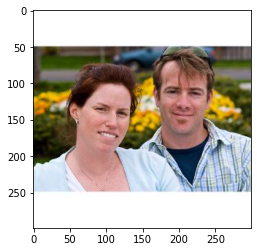

Real caption Descriptions :
_________________________
man and woman are posing for photograph in front of yellow flowerbed
man and woman in front of the yellow flowers
man and woman smile for the camera while standing outside
red haired girl smiling sitting next to brown haired man who is also smiling
couple posing for picture with white and yellow flowers in the background
_____________________________________
Caption: woman with blond smiles
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.211734
Individual 2-gram: 0.108342
Individual 3-gram: 0.067603
Individual 4-gram: 0.036989
_____________________________________
Cumulative 1-gram: 0.211734
Cumulative 2-gram: 0.151459
Cumulative 3-gram: 0.116803
Cumulative 4-gram: 0.087028
**************************************************************


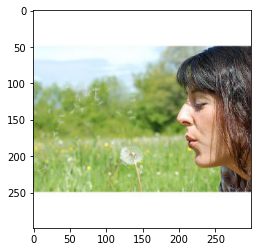

Real caption Descriptions :
_________________________
woman blowing on dandelion
woman blowing on milkweed in field
woman in grassy field blows on dandelion
woman is blowing the seeds from dandelion
the woman is blowing the pods off flower in green field
_____________________________________
Caption: girl with ponytail looks at sprinkler
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.000000
Individual 2-gram: 0.000000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
_____________________________________
Cumulative 1-gram: 0.000000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000
**************************************************************


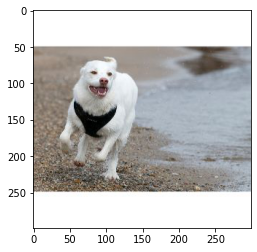

Real caption Descriptions :
_________________________
white dog running on rocky beach
white dog running on the beach
white dog runs with one ear up
white dog with black chest piece runs along the shore of grainy beach
white dog with black harness runs on rocky shore
_____________________________________
Caption: startseq dog is running on the sand
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.825397
Individual 2-gram: 0.452910
Individual 3-gram: 0.277487
Individual 4-gram: 0.152345
_____________________________________
Cumulative 1-gram: 0.825397
Cumulative 2-gram: 0.611417
Cumulative 3-gram: 0.473426
Cumulative 4-gram: 0.354557
**************************************************************


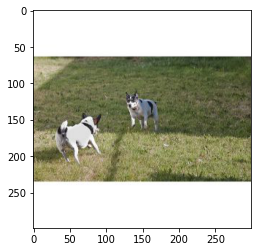

Real caption Descriptions :
_________________________
two black and white dogs running towards each other in the grass
two dogs approach each other in the grass
two dogs are playing out in yard
two dogs face off in the park
two dogs face off of each other on the grass
_____________________________________
Caption: two dogs play in field
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.547428
Individual 2-gram: 0.282091
Individual 3-gram: 0.174374
Individual 4-gram: 0.094714
_____________________________________
Cumulative 1-gram: 0.547428
Cumulative 2-gram: 0.392969
Cumulative 3-gram: 0.302154
Cumulative 4-gram: 0.224726
**************************************************************


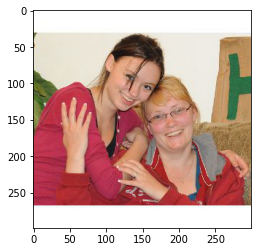

Real caption Descriptions :
_________________________
girl and woman pose for picture
woman and young woman pose with their arms around each other
young girl posing with another woman each smiling
two women smile cheerfully at the viewer
two women wearing red are smiling at the camera
_____________________________________
Caption: woman and woman are smiling at the camera
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 1.285714
Individual 2-gram: 0.880952
Individual 3-gram: 0.593651
Individual 4-gram: 0.414550
_____________________________________
Cumulative 1-gram: 1.285714
Cumulative 2-gram: 1.064262
Cumulative 3-gram: 0.877238
Cumulative 4-gram: 0.726610
**************************************************************


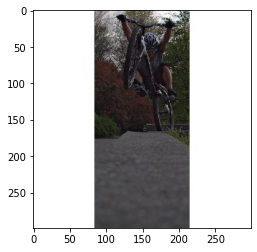

Real caption Descriptions :
_________________________
bicyclist is attempting trick while wearing minimal protective gear
boy attempting jump on his bike
boy is riding his bike over ramp at park
closeup of man riding bicycle
man in helmet is doing stunts on bike
_____________________________________
Caption: man wearing no shirt rides his bmx bike down the hill
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.683802
Individual 2-gram: 0.417574
Individual 3-gram: 0.286338
Individual 4-gram: 0.160996
_____________________________________
Cumulative 1-gram: 0.683802
Cumulative 2-gram: 0.534357
Cumulative 3-gram: 0.437662
Cumulative 4-gram: 0.338719
**************************************************************


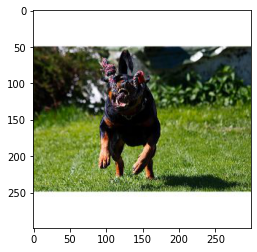

Real caption Descriptions :
_________________________
black and brown dog has rope in its mouth
dog jumps to catch rope toy
dog with rope toy in its mouth runs on the grass
large dog is running on the grass with rope in its mouth
the dog is running with rope toy
_____________________________________
Caption: black and brown dog startseq startseq on its mouth
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 1.018519
Individual 2-gram: 0.601411
Individual 3-gram: 0.351264
Individual 4-gram: 0.172644
_____________________________________
Cumulative 1-gram: 1.018519
Cumulative 2-gram: 0.782655
Cumulative 3-gram: 0.602303
Cumulative 4-gram: 0.439017
**************************************************************


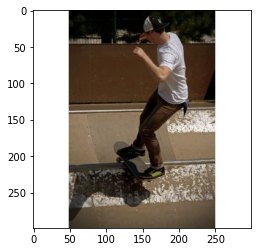

Real caption Descriptions :
_________________________
man does skateboard trick on snowy ground
skateboarder in black brown and white is grinding his skateboard along low rail
young man rides skateboard along metal pole
the skater rides his board on the pipe
the young man is riding skateboard and performing trick
_____________________________________
Caption: skateboarder is doing trick on ramp
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.714807
Individual 2-gram: 0.353600
Individual 3-gram: 0.225494
Individual 4-gram: 0.123892
_____________________________________
Cumulative 1-gram: 0.714807
Cumulative 2-gram: 0.502748
Cumulative 3-gram: 0.387884
Cumulative 4-gram: 0.289881
**************************************************************


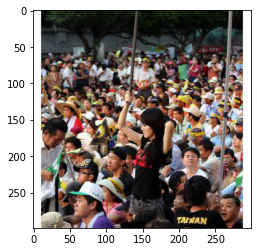

Real caption Descriptions :
_________________________
crowd of people gathered together and one woman is standing and holding sign
group of fans gather for some type of event
asian crowd with attractive woman in foreground
girl in black and red shirt is standing up with pole in her hand surrounded by people
young woman standing above crowd
_____________________________________
Caption: crowd of people parade around
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.900000
Individual 2-gram: 0.577778
Individual 3-gram: 0.358289
Individual 4-gram: 0.174015
_____________________________________
Cumulative 1-gram: 0.900000
Cumulative 2-gram: 0.721110
Cumulative 3-gram: 0.574352
Cumulative 4-gram: 0.424332
**************************************************************


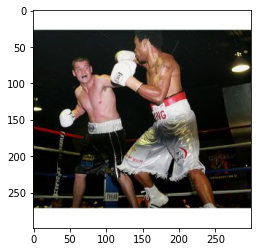

Real caption Descriptions :
_________________________
boxer in black trunks taking swing at boxer in white trunks
man in black shorts is boxing against and man in white shorts
man wearing black boxing shorts and white boxing gloves and man in white boxing shorts and white boxing gloves are fighting in the ring
two boxers fight in welllit ring surrounded by poorlylit seating
two men battle it out in boxing match with white gloves
_____________________________________
Caption: two wrestlers wrestlers wrestler in match match net wrestler match net
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.623196
Individual 2-gram: 0.397372
Individual 3-gram: 0.279604
Individual 4-gram: 0.158751
_____________________________________
Cumulative 1-gram: 0.623196
Cumulative 2-gram: 0.497635
Cumulative 3-gram: 0.414305
Cumulative 4-gram: 0.323795
**************************************************************


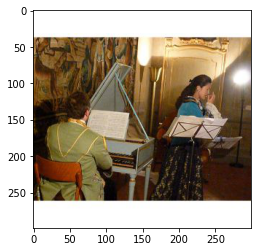

Real caption Descriptions :
_________________________
man dressed in green jacket is playing piano while woman sings
man is sitting in front of harpsichord and woman is preparing to sing
person playing the piano with singer nearby
pianist and singer are ready to perform
the man in the green jacket is playing the piano next to woman who is by music stand
_____________________________________
Caption: woman is sitting at table and playing at chair
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.787037
Individual 2-gram: 0.423641
Individual 3-gram: 0.282359
Individual 4-gram: 0.157304
_____________________________________
Cumulative 1-gram: 0.787037
Cumulative 2-gram: 0.577426
Cumulative 3-gram: 0.458514
Cumulative 4-gram: 0.348846
**************************************************************


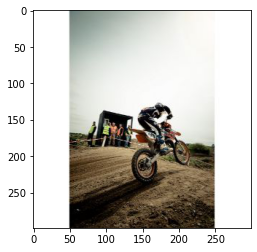

Real caption Descriptions :
_________________________
dirt bike racer takes offf as others watch
motocross rider is traveling along dirt path with people watching
person on dirt bike is riding up hill while people watch on the side
person riding dirt bike
person riding dirt bike on track while others stand by track
_____________________________________
Caption: man sits on bike
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.739024
Individual 2-gram: 0.378152
Individual 3-gram: 0.235956
Individual 4-gram: 0.129106
_____________________________________
Cumulative 1-gram: 0.739024
Cumulative 2-gram: 0.528643
Cumulative 3-gram: 0.407682
Cumulative 4-gram: 0.303756
**************************************************************


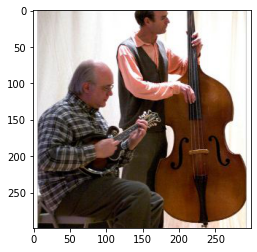

Real caption Descriptions :
_________________________
man with double bass and man with mandolin play music
seated man playing small guitar next to standing man plucking bass
one man sitting playing small guitar while another man is standing playing large chello
the two gentleman are playing stringed instruments
two men play instruments
_____________________________________
Caption: man playing with guitar in the hand
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.865079
Individual 2-gram: 0.416863
Individual 3-gram: 0.271752
Individual 4-gram: 0.150434
_____________________________________
Cumulative 1-gram: 0.865079
Cumulative 2-gram: 0.600516
Cumulative 3-gram: 0.464626
Cumulative 4-gram: 0.348451
**************************************************************


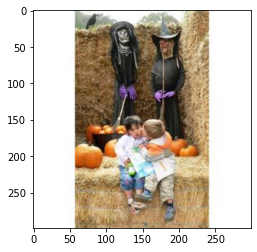

Real caption Descriptions :
_________________________
little boy kisses little girl as they sit on hay bale with pumpkins and halloween display in the background
little boy kisses little girl while sitting on hay bales surrounded by halloween decorations
little boy kissing girl on stack of hay
two children are sitting on bales of hay in halloween themed setting
two children are sitting on hay in front of pumpkins and play witches
_____________________________________
Caption: girl in red furry suit splashes
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.461083
Individual 2-gram: 0.266562
Individual 3-gram: 0.179958
Individual 4-gram: 0.101233
_____________________________________
Cumulative 1-gram: 0.461083
Cumulative 2-gram: 0.350581
Cumulative 3-gram: 0.283348
Cumulative 4-gram: 0.217530
**************************************************************


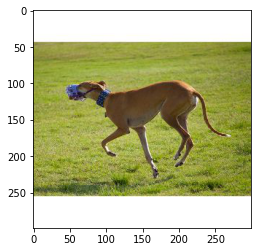

Real caption Descriptions :
_________________________
big tan dog wearing muzzle running in green grass
brown dog wears blue muzzle as it runs in the grass
brown dog with blue muzzle is running on green grass
brown greyhound is wearing blue muzzle and blue collar
the brown dog with the blue muzzle is in the field
_____________________________________
Caption: dog with muzzle running in the grass
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.960221
Individual 2-gram: 0.629014
Individual 3-gram: 0.354844
Individual 4-gram: 0.163257
_____________________________________
Cumulative 1-gram: 0.960221
Cumulative 2-gram: 0.777170
Cumulative 3-gram: 0.599808
Cumulative 4-gram: 0.432499
**************************************************************


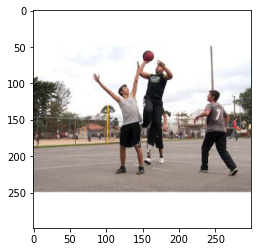

Real caption Descriptions :
_________________________
guy jumps to make basketball shot
four men playing basketball on court with various people in the background
the man drives the lane for shot in the outdoor basketball game
the three men are playing basketball on blacktop
three men are playing basketball and one of them blocked the others shot while people play in the back
_____________________________________
Caption: two men are playing game
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.846022
Individual 2-gram: 0.509432
Individual 3-gram: 0.305471
Individual 4-gram: 0.146514
_____________________________________
Cumulative 1-gram: 0.846022
Cumulative 2-gram: 0.656499
Cumulative 3-gram: 0.511147
Cumulative 4-gram: 0.372674
**************************************************************


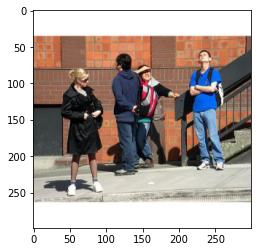

Real caption Descriptions :
_________________________
girl in black coat next to some school kids
four teenagers are standing at the foot of some steps by brick wall
kids are waiting at the bottom of staircase attached to brick building
peoople stand outside building near street
teenagers congregate outside brick building
_____________________________________
Caption: three men in hats standing on the sidewalk talking to the right
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.666219
Individual 2-gram: 0.415817
Individual 3-gram: 0.288192
Individual 4-gram: 0.162569
_____________________________________
Cumulative 1-gram: 0.666219
Cumulative 2-gram: 0.526332
Cumulative 3-gram: 0.434236
Cumulative 4-gram: 0.337528
**************************************************************


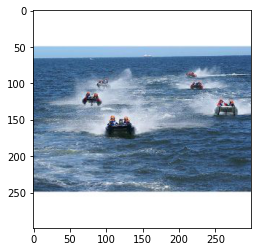

Real caption Descriptions :
_________________________
group of people in boats racing towards the shore
group of people race with boats
people in speed rafts drive in the water
people on watercraft play in the ocean
people riding on ski boats in the ocean
_____________________________________
Caption: the boat is driving across the water
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.579365
Individual 2-gram: 0.321625
Individual 3-gram: 0.240006
Individual 4-gram: 0.139852
_____________________________________
Cumulative 1-gram: 0.579365
Cumulative 2-gram: 0.431669
Cumulative 3-gram: 0.358652
Cumulative 4-gram: 0.281221
**************************************************************


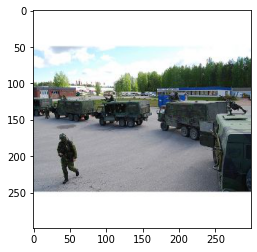

Real caption Descriptions :
_________________________
convoy of military trucks are lined up in lot
line of military trucks are passing by soldier who is walking away
man in military uniform is walking away from line of military vehicles
military man walks away from line of army vehicles
army vehicles line up and soldier walks near them
_____________________________________
Caption: startseq hangs in front of group of people off
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.583244
Individual 2-gram: 0.374139
Individual 3-gram: 0.265859
Individual 4-gram: 0.151804
_____________________________________
Cumulative 1-gram: 0.583244
Cumulative 2-gram: 0.467134
Cumulative 3-gram: 0.390811
Cumulative 4-gram: 0.306340
**************************************************************


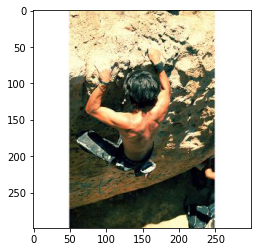

Real caption Descriptions :
_________________________
man climbing up on rock ledge
man climbs some rocks
man in black pants climbing rock wall
man without shirt climbing rock face
the man is scaling large brown boulder
_____________________________________
Caption: man in bathing suit pointing off his arms
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.547619
Individual 2-gram: 0.305839
Individual 3-gram: 0.239304
Individual 4-gram: 0.141445
_____________________________________
Cumulative 1-gram: 0.547619
Cumulative 2-gram: 0.409247
Cumulative 3-gram: 0.345911
Cumulative 4-gram: 0.274396
**************************************************************


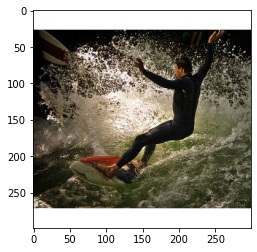

Real caption Descriptions :
_________________________
man falling off of his surfboard
man in black wetsuit rides surfboard on wave
surfer in wetsuit balances on his board amidst ocean spray
surfer leaning back on surfboard
this man is wearing wetsuit and riding surfboard
_____________________________________
Caption: girl does large rock in the water
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.521955
Individual 2-gram: 0.340317
Individual 3-gram: 0.246236
Individual 4-gram: 0.141929
_____________________________________
Cumulative 1-gram: 0.521955
Cumulative 2-gram: 0.421462
Cumulative 3-gram: 0.356030
Cumulative 4-gram: 0.280695
**************************************************************


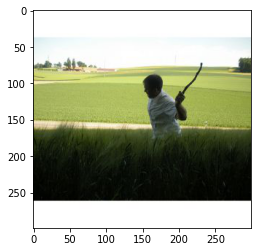

Real caption Descriptions :
_________________________
man in white shirt swinging stick
man in white shirt walks in the tall grass holding stick
man is walking in field carrying stick
man with stick in his left hand in field
man near golf course preparing to throw stick
_____________________________________
Caption: little girl in pink shirt is swinging on the grass
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.838437
Individual 2-gram: 0.464490
Individual 3-gram: 0.299194
Individual 4-gram: 0.164188
_____________________________________
Cumulative 1-gram: 0.838437
Cumulative 2-gram: 0.624056
Cumulative 3-gram: 0.491940
Cumulative 4-gram: 0.371908
**************************************************************


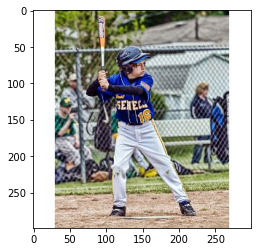

Real caption Descriptions :
_________________________
boy holds the bat waiting for the pitch at baseball game
little boy batting in baseball game
young boy in blue and white uniform is up to bat at baseball game
boy plays baseball
boy wearing blue white and yellow baseball uniform about to hit ball
_____________________________________
Caption: the young baseball player is the baseball game
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.880952
Individual 2-gram: 0.416950
Individual 3-gram: 0.276341
Individual 4-gram: 0.153791
_____________________________________
Cumulative 1-gram: 0.880952
Cumulative 2-gram: 0.606064
Cumulative 3-gram: 0.470044
Cumulative 4-gram: 0.353470
**************************************************************


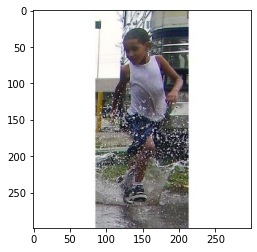

Real caption Descriptions :
_________________________
boy runs through the puddle
boy splashing in puddle
young boy is running through large puddle outside
young boy is splashing through puddle of water
young boy playing in the water
_____________________________________
Caption: little girl girl in pink outfit splashes splashing water
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.657318
Individual 2-gram: 0.398830
Individual 3-gram: 0.274089
Individual 4-gram: 0.154547
_____________________________________
Cumulative 1-gram: 0.657318
Cumulative 2-gram: 0.512014
Cumulative 3-gram: 0.419402
Cumulative 4-gram: 0.324623
**************************************************************


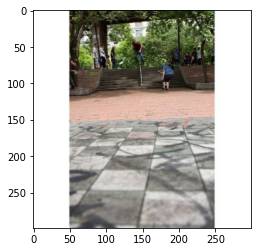

Real caption Descriptions :
_________________________
man grinding down handrail
man is skating down rail in front of group of people
in the far distance boy is sliding his skateboard down handrail
some skateboarders on stairs
the man is skateboarding down the railing in the middle of the steps
_____________________________________
Caption: man in red shirt is jumping on the sidewalk
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.644967
Individual 2-gram: 0.358901
Individual 3-gram: 0.232654
Individual 4-gram: 0.128145
_____________________________________
Cumulative 1-gram: 0.644967
Cumulative 2-gram: 0.481123
Cumulative 3-gram: 0.380486
Cumulative 4-gram: 0.288225
**************************************************************


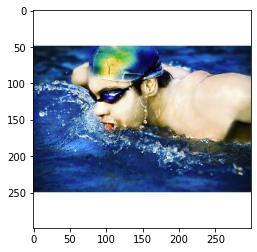

Real caption Descriptions :
_________________________
man in blue goggles is in the swimming pool
man with blue yellow and green swimming cap is wearing goggles and swimming
swimmer doing the breaststroke in pool
swimmer swimming butterfly in pool
the swimmer is wearing green and yellow hat and goggles
_____________________________________
Caption: woman in swimming goggles
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.705353
Individual 2-gram: 0.337771
Individual 3-gram: 0.198185
Individual 4-gram: 0.105355
_____________________________________
Cumulative 1-gram: 0.705353
Cumulative 2-gram: 0.488107
Cumulative 3-gram: 0.364223
Cumulative 4-gram: 0.265576
**************************************************************


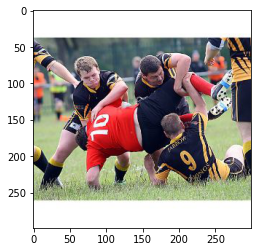

Real caption Descriptions :
_________________________
group of young men in sports uniforms from two opposing teams are in vigorous play on grassy field
three men tackle someone from the opposite team
three men wearing the same black and yellow uniform are blocking another man in red uniform
three players bring team opponent to the ground
three rugby players in black strips are pulling the player in red to the ground
_____________________________________
Caption: group of men for performs for the ball
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.714286
Individual 2-gram: 0.361395
Individual 3-gram: 0.257822
Individual 4-gram: 0.147618
_____________________________________
Cumulative 1-gram: 0.714286
Cumulative 2-gram: 0.508074
Cumulative 3-gram: 0.408929
Cumulative 4-gram: 0.314832
**************************************************************


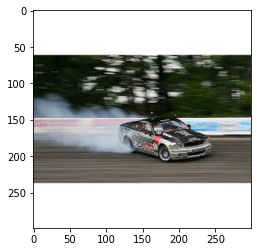

Real caption Descriptions :
_________________________
race car spinning out of control on racetrack
race car spins on the track
silver and black race car turns sideways and blows smoke out the back of the car
silver car goes out of control on racetrack
the grey car skidded down the track
_____________________________________
Caption: race car driving wet road
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.559466
Individual 2-gram: 0.308158
Individual 3-gram: 0.200852
Individual 4-gram: 0.111641
_____________________________________
Cumulative 1-gram: 0.559466
Cumulative 2-gram: 0.415216
Cumulative 3-gram: 0.328958
Cumulative 4-gram: 0.249351
**************************************************************


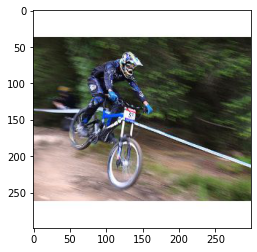

Real caption Descriptions :
_________________________
bmx racer comes down hill everything around him is blur
dirt biker rides down trail
man in blue is riding bicycle on track
mountain biker is giong down hill on his bike
mountain biker on blue mountain bike gets air time
_____________________________________
Caption: two bmx riders in bmx race
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.643493
Individual 2-gram: 0.372017
Individual 3-gram: 0.251152
Individual 4-gram: 0.141282
_____________________________________
Cumulative 1-gram: 0.643493
Cumulative 2-gram: 0.489276
Cumulative 3-gram: 0.395444
Cumulative 4-gram: 0.303587
**************************************************************


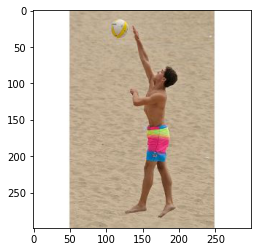

Real caption Descriptions :
_________________________
man in bright shorts hits volleyball in the sand
man in colourful shorts reaching up to hit volleyball
man on the sand wearing blue pink and yellow shorts
shirtless man in colorful shorts spikes volleyball during beach volleyball game
the young man leaps to serve the volleyball on the beach
_____________________________________
Caption: female volleyball player in the volleyball match
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.620267
Individual 2-gram: 0.345072
Individual 3-gram: 0.214818
Individual 4-gram: 0.116582
_____________________________________
Cumulative 1-gram: 0.620267
Cumulative 2-gram: 0.462641
Cumulative 3-gram: 0.360914
Cumulative 4-gram: 0.270581
**************************************************************


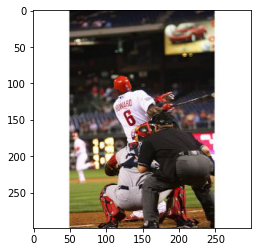

Real caption Descriptions :
_________________________
baseball player just taking swing at stadium
baseball player swings the bat as catcher and umpire watch
batsman is about to swing for baseball whilst the catcher and referee wait behind him
an ump in black watches baseball game
the baseball player takes swing
_____________________________________
Caption: one man for ball in game
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.754605
Individual 2-gram: 0.409054
Individual 3-gram: 0.263498
Individual 4-gram: 0.145398
_____________________________________
Cumulative 1-gram: 0.754605
Cumulative 2-gram: 0.555585
Cumulative 3-gram: 0.436910
Cumulative 4-gram: 0.329768
**************************************************************


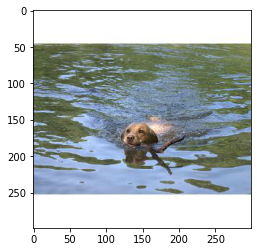

Real caption Descriptions :
_________________________
brown dog swimming through lake with stick in his mouth
brown dog swimming with stick
dog holding stick swims in the water
dog swimming with stick in its mouth
golden dog swims with stick in its mouth
_____________________________________
Caption: brown dog swims through water
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 1.166667
Individual 2-gram: 0.620830
Individual 3-gram: 0.326802
Individual 4-gram: 0.163519
_____________________________________
Cumulative 1-gram: 1.166667
Cumulative 2-gram: 0.851059
Cumulative 3-gram: 0.621566
Cumulative 4-gram: 0.443551
**************************************************************


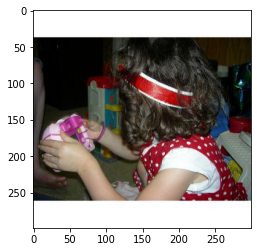

Real caption Descriptions :
_________________________
girl in red polka dot dress and red headband playing with pink handheld game
girl in red and white plays with purple toy
girl with camera looking at the screen
girl with red headband is holding pink camera
one young girl dressed in red polka dot outfit plays with toy
_____________________________________
Caption: the girl is using paint paint
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.638759
Individual 2-gram: 0.346257
Individual 3-gram: 0.223046
Individual 4-gram: 0.123076
_____________________________________
Cumulative 1-gram: 0.638759
Cumulative 2-gram: 0.470292
Cumulative 3-gram: 0.369836
Cumulative 4-gram: 0.279143
**************************************************************


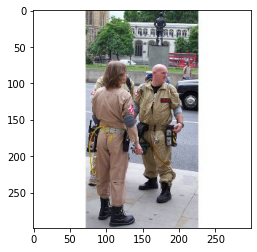

Real caption Descriptions :
_________________________
man and woman are dressed up as ghost busters on city street
people in ghostbusters outfits stand on sidewalk
three ghostbuster impersonators
three people in uniform are outdoors and are observing scene which is out of the picture
two people dressed up like the ghostbusters standing on the sidewalk
_____________________________________
Caption: woman in black and black outfit walking away the sidewalk
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.636737
Individual 2-gram: 0.318062
Individual 3-gram: 0.236647
Individual 4-gram: 0.137205
_____________________________________
Cumulative 1-gram: 0.636737
Cumulative 2-gram: 0.450024
Cumulative 3-gram: 0.366568
Cumulative 4-gram: 0.284764
**************************************************************


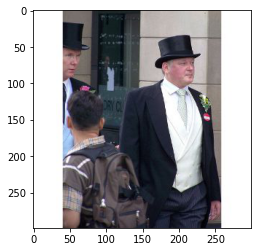

Real caption Descriptions :
_________________________
man wearing formal suit and hat stands next to building
man wearing tuxedo and top hat standing outside with some other people to hi right
two men dressed up walk along the street while another man stares at them
two men in top hats and tuxedos are walking past dry cleaning store and casual man who is looking at them
two men in tuxedos and tophats stand on the street as boy with backpack passes by
_____________________________________
Caption: older man in blue coat and older walking
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.595453
Individual 2-gram: 0.333676
Individual 3-gram: 0.218200
Individual 4-gram: 0.120767
_____________________________________
Cumulative 1-gram: 0.595453
Cumulative 2-gram: 0.445745
Cumulative 3-gram: 0.354106
Cumulative 4-gram: 0.268995
**************************************************************


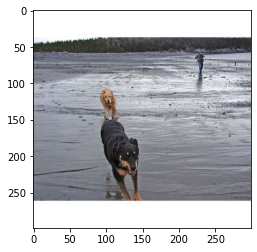

Real caption Descriptions :
_________________________
brown dog and tan dog run on beach
dogs chase each other through water
the black dog and the brown dog are on the ground
two dogs play in shallow water
two dogs running on the beach
_____________________________________
Caption: two dogs two black and one black and dark dog are each each other steps on the bank of the bank startseq
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.730159
Individual 2-gram: 0.399021
Individual 3-gram: 0.297338
Individual 4-gram: 0.171300
_____________________________________
Cumulative 1-gram: 0.730159
Cumulative 2-gram: 0.539767
Cumulative 3-gram: 0.446096
Cumulative 4-gram: 0.349024
**************************************************************


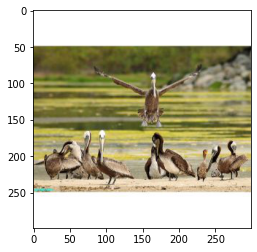

Real caption Descriptions :
_________________________
pelican in midflight above group of pelicans
birds flocking by the water edge
large birds standing on the edge of body of water while one in the middle is coming down for landing
one bird is landing on the shore near many other birds
there are several pelicans and one is flying
_____________________________________
Caption: blue wings prepares for small surface
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.532382
Individual 2-gram: 0.334980
Individual 3-gram: 0.238806
Individual 4-gram: 0.137167
_____________________________________
Cumulative 1-gram: 0.532382
Cumulative 2-gram: 0.422300
Cumulative 3-gram: 0.352911
Cumulative 4-gram: 0.276462
**************************************************************


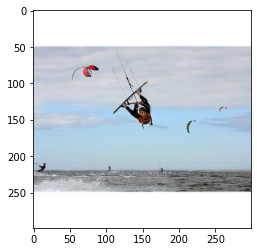

Real caption Descriptions :
_________________________
kite surfer jumps through the air
man is flying through the air hanging from paraglider while others are waterskiing
person is parasailing over water with other parasailors close behind him
person wearing lifevest is in the air above water
young man parasailing in midair over the ocean
_____________________________________
Caption: man is on the water
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.777794
Individual 2-gram: 0.380934
Individual 3-gram: 0.225110
Individual 4-gram: 0.119727
_____________________________________
Cumulative 1-gram: 0.777794
Cumulative 2-gram: 0.544324
Cumulative 3-gram: 0.408402
Cumulative 4-gram: 0.298934
**************************************************************


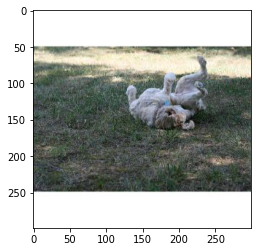

Real caption Descriptions :
_________________________
dog rolls in the grass
small white dog rolls over on the grass
tan dog rolls in the grass
the grey dog is rolling on its back on the grass
the yellow dog wears blue dog tag and rolls on green field
_____________________________________
Caption: two dogs are playing together on the grass
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.678571
Individual 2-gram: 0.376984
Individual 3-gram: 0.242894
Individual 4-gram: 0.142642
_____________________________________
Cumulative 1-gram: 0.678571
Cumulative 2-gram: 0.505777
Cumulative 3-gram: 0.399761
Cumulative 4-gram: 0.306828
**************************************************************


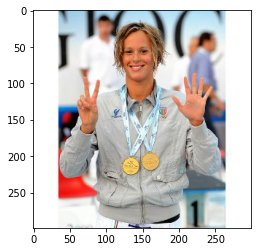

Real caption Descriptions :
_________________________
an olympic winner takes home two medals
an olympic winner wearing her two gold medals and grey jacket showing peace sign and wave
woman wearing two medals holds up seven fingers
woman wearing two gold medals holding up her hands
woman with two medals around her neck holding up seven fingers
_____________________________________
Caption: girl with girl in blue shirt biting her finger
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.583244
Individual 2-gram: 0.374139
Individual 3-gram: 0.265859
Individual 4-gram: 0.151804
_____________________________________
Cumulative 1-gram: 0.583244
Cumulative 2-gram: 0.467134
Cumulative 3-gram: 0.390811
Cumulative 4-gram: 0.306340
**************************************************************


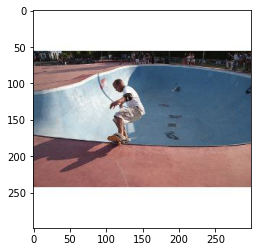

Real caption Descriptions :
_________________________
man in skateboarding in an empty swimming pool
man rides skateboard up the side of an empty pool
skateboarder dressed in white is dropping into blue bowl
skateboarder hanging off the edge of bowl at skate park
skateboarder in an empty pool
_____________________________________
Caption: woman is jumping on trampoline
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.547835
Individual 2-gram: 0.329055
Individual 3-gram: 0.229544
Individual 4-gram: 0.131100
_____________________________________
Cumulative 1-gram: 0.547835
Cumulative 2-gram: 0.424579
Cumulative 3-gram: 0.349574
Cumulative 4-gram: 0.271392
**************************************************************


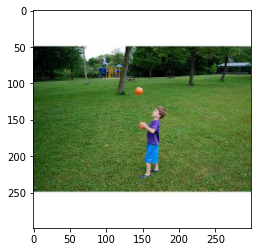

Real caption Descriptions :
_________________________
boy in park playing with two orange balls
boy in purple shirt tosses orange balls on lawn
little boy in purple shirt and blue shorts playing with orange balls
boy playing on the grass with an orange ball
little boy juggling orange balls in the park with playground behind him
_____________________________________
Caption: blue blue dog running after blue ball
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.535031
Individual 2-gram: 0.322533
Individual 3-gram: 0.222630
Individual 4-gram: 0.126093
_____________________________________
Cumulative 1-gram: 0.535031
Cumulative 2-gram: 0.415410
Cumulative 3-gram: 0.340625
Cumulative 4-gram: 0.263819
**************************************************************


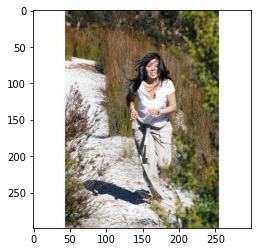

Real caption Descriptions :
_________________________
an asian girl is running outside
an asian woman is running on rocky path
woman runs on chalk white path
woman runs on the beach
woman with long black hair and white shirt is running up the sand and tall weeds
_____________________________________
Caption: man in red rock climbing
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.000000
Individual 2-gram: 0.000000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
_____________________________________
Cumulative 1-gram: 0.000000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000
**************************************************************


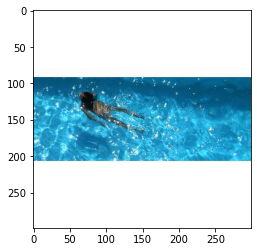

Real caption Descriptions :
_________________________
girl is swimming in clear water in blue pool
girl swims through clear blue water
person is swimming underwater in pool
person swimming underwater in swimming pool
picture of somebody under blue water
_____________________________________
Caption: the black dog swims in pool about to catch red ball
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.548485
Individual 2-gram: 0.297758
Individual 3-gram: 0.246399
Individual 4-gram: 0.147683
_____________________________________
Cumulative 1-gram: 0.548485
Cumulative 2-gram: 0.404123
Cumulative 3-gram: 0.346370
Cumulative 4-gram: 0.277651
**************************************************************


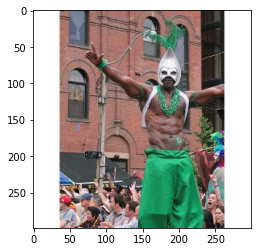

Real caption Descriptions :
_________________________
dark man in white and green feathered mask with green jewelry and pants
man in costume participates in parade
man in green and silver mardi gras costume in parade
man is wearing mask green beads and green pants
man dresses up in hawaiian garb at local parade
_____________________________________
Caption: two girls in costume perform onstage onstage outfits outfits outfits
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.503704
Individual 2-gram: 0.284846
Individual 3-gram: 0.239313
Individual 4-gram: 0.144227
_____________________________________
Cumulative 1-gram: 0.503704
Cumulative 2-gram: 0.378785
Cumulative 3-gram: 0.328699
Cumulative 4-gram: 0.265277
**************************************************************


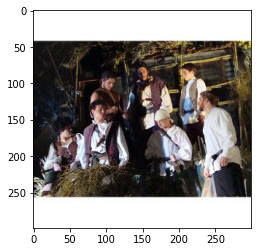

Real caption Descriptions :
_________________________
group of men in period clothing are standing in front of hut
group of people dressed as pirates
the people are in older looking attire
the people in white and maroon clothes are in wooden building
the seven men are gathered
_____________________________________
Caption: four asian women outdoors together
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.000000
Individual 2-gram: 0.000000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
_____________________________________
Cumulative 1-gram: 0.000000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000
**************************************************************


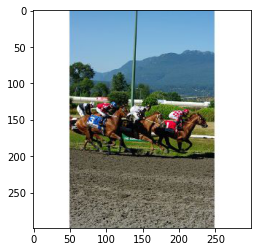

Real caption Descriptions :
_________________________
professional horse race
four jockeys and their horses race towards the finish line at racetrack
horses with jockeys participate in race
jockeys ride their horses down the track during horse race
three horses and their jockeys compete in race
_____________________________________
Caption: group of people are sitting on the grass with view of group of plants
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.543728
Individual 2-gram: 0.381987
Individual 3-gram: 0.281019
Individual 4-gram: 0.161775
_____________________________________
Cumulative 1-gram: 0.543728
Cumulative 2-gram: 0.455738
Cumulative 3-gram: 0.391593
Cumulative 4-gram: 0.311724
**************************************************************


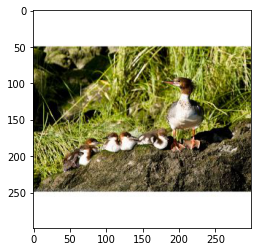

Real caption Descriptions :
_________________________
bird is standing on rock next to her six babies
mommy duck walking along some rocks with group of baby ducks
an adult duck stands on rock with seven baby ducks nearby
the mother bird looks over her babies
there is grown duck and several baby ducks
_____________________________________
Caption: the is the
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.220848
Individual 2-gram: 0.102856
Individual 3-gram: 0.059334
Individual 4-gram: 0.031414
_____________________________________
Cumulative 1-gram: 0.220848
Cumulative 2-gram: 0.150717
Cumulative 3-gram: 0.111426
Cumulative 4-gram: 0.080665
**************************************************************


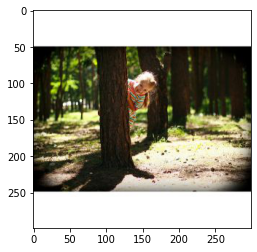

Real caption Descriptions :
_________________________
little girl is peaking out from behind tree
little girl peering out from behind tree
young girl hiding behind tree in forest
young girl peeking out from behind tree in wooded area
young girl wearing striped dress peeks out from behind tree
_____________________________________
Caption: the child is posing for picture
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.450652
Individual 2-gram: 0.283555
Individual 3-gram: 0.202145
Individual 4-gram: 0.116110
_____________________________________
Cumulative 1-gram: 0.450652
Cumulative 2-gram: 0.357469
Cumulative 3-gram: 0.298733
Cumulative 4-gram: 0.234020
**************************************************************


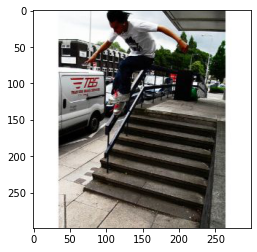

Real caption Descriptions :
_________________________
boy wearing white shirt and pink shoelaces jumping on railing
man jumps of the handrail of an outdoor staircase
person on skateboard
skateboarder is balancing on the rail of stairs
teenage boy jumps off rail
_____________________________________
Caption: boy does tricks on skateboard
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.816667
Individual 2-gram: 0.420830
Individual 3-gram: 0.260136
Individual 4-gram: 0.141297
_____________________________________
Cumulative 1-gram: 0.816667
Cumulative 2-gram: 0.586240
Cumulative 3-gram: 0.450760
Cumulative 4-gram: 0.335252
**************************************************************


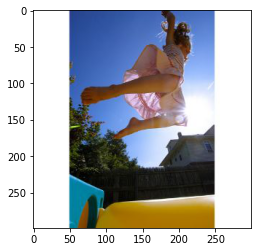

Real caption Descriptions :
_________________________
girl in pink dress in midair over large yellow object
girl in pink shirt has jumped into the air
girl is jumping
young girl jumping through the air on playground
young girl wearing pink dress jumps through the air over playground equipment
_____________________________________
Caption: boy jumps on the trampoline
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.814502
Individual 2-gram: 0.417943
Individual 3-gram: 0.259174
Individual 4-gram: 0.140976
_____________________________________
Cumulative 1-gram: 0.814502
Cumulative 2-gram: 0.583452
Cumulative 3-gram: 0.448795
Cumulative 4-gram: 0.333954
**************************************************************


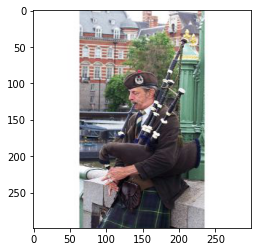

Real caption Descriptions :
_________________________
man playing bagpipes
man plays the bagpipes
man wearing coat and plaid green skirt is playing bagpipe
man wearing kilt is playing the bagpipes
an older man playing wearing quilt the bagpipes outside
_____________________________________
Caption: woman in black dress and hat sits on the grass
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.571770
Individual 2-gram: 0.375602
Individual 3-gram: 0.269565
Individual 4-gram: 0.154311
_____________________________________
Cumulative 1-gram: 0.571770
Cumulative 2-gram: 0.463420
Cumulative 3-gram: 0.390537
Cumulative 4-gram: 0.307434
**************************************************************


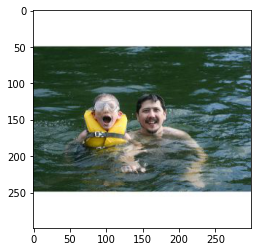

Real caption Descriptions :
_________________________
boy with his mouth wide open dressed in yellow life jacket and goggles in water with man next to him
father and child enjoy the water
man and child wearing yellow life vest look up from the water
an open mouthed child in goggles and yellow life vest poses with smiling man
man and boy wearing life jacket in water posing for picture
_____________________________________
Caption: child swims in pool
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.448241
Individual 2-gram: 0.229361
Individual 3-gram: 0.143115
Individual 4-gram: 0.078307
_____________________________________
Cumulative 1-gram: 0.448241
Cumulative 2-gram: 0.320638
Cumulative 3-gram: 0.247272
Cumulative 4-gram: 0.184238
**************************************************************


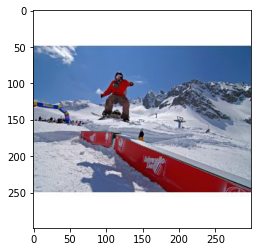

Real caption Descriptions :
_________________________
guy in red jacket is snowboarding in midair
man is snowboarding down railing in the snow
man skiing down hill and over red obstacle
person snowboarding leaps over an obstacle to continue down the hill
snowboarder jumps over ramp on mountain course
_____________________________________
Caption: the climber is wearing the snow
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.620753
Individual 2-gram: 0.322249
Individual 3-gram: 0.215044
Individual 4-gram: 0.120409
_____________________________________
Cumulative 1-gram: 0.620753
Cumulative 2-gram: 0.447255
Cumulative 3-gram: 0.353489
Cumulative 4-gram: 0.268271
**************************************************************


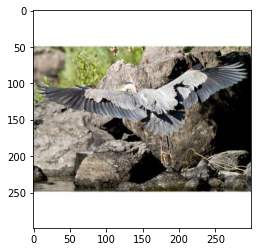

Real caption Descriptions :
_________________________
bird has its wings spread very wide and is standing on rocks
bird takes off surrounded by large rocks
grey bird flies over the water by some rocks
large duck in flight over rocky stream
seabird is flying over rocks
_____________________________________
Caption: the bird is sitting next to rocks
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.807670
Individual 2-gram: 0.435555
Individual 3-gram: 0.277982
Individual 4-gram: 0.152511
_____________________________________
Cumulative 1-gram: 0.807670
Cumulative 2-gram: 0.593114
Cumulative 3-gram: 0.464298
Cumulative 4-gram: 0.349461
**************************************************************


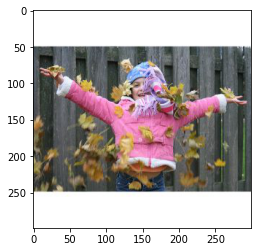

Real caption Descriptions :
_________________________
girl in pink coat plays in the leaves
girl in pink coat throws leaves in the air
little girl in pink jacket throwing some leafs up in the air
little girl in pink jacket throws leaves over her head in front of fence
young girl in pink coat throwing leaves into the air
_____________________________________
Caption: woman in outfit bending climbing wall
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.381469
Individual 2-gram: 0.240024
Individual 3-gram: 0.171112
Individual 4-gram: 0.098285
_____________________________________
Cumulative 1-gram: 0.381469
Cumulative 2-gram: 0.302591
Cumulative 3-gram: 0.252872
Cumulative 4-gram: 0.198093
**************************************************************


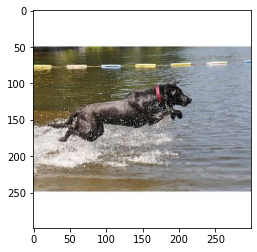

Real caption Descriptions :
_________________________
black dog jumping into lake
black dog with red collar is jumping in the water
black dog with red collar is jumping out of the water
black dog with red collar splashing in water
the black dog with red collar is jumping through the water
_____________________________________
Caption: black dog in water
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.951868
Individual 2-gram: 0.536658
Individual 3-gram: 0.264481
Individual 4-gram: 0.127453
_____________________________________
Cumulative 1-gram: 0.951868
Cumulative 2-gram: 0.714722
Cumulative 3-gram: 0.515270
Cumulative 4-gram: 0.362247
**************************************************************


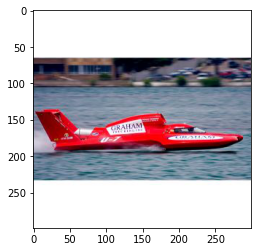

Real caption Descriptions :
_________________________
red covered boat racing across the water
red high speed racing boat skips across the water
red speed boat crosses the water
watercraft speeds through the water
red boat marked graham races across water
_____________________________________
Caption: boat on the
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.430154
Individual 2-gram: 0.200337
Individual 3-gram: 0.115566
Individual 4-gram: 0.061186
_____________________________________
Cumulative 1-gram: 0.430154
Cumulative 2-gram: 0.293557
Cumulative 3-gram: 0.217028
Cumulative 4-gram: 0.157115
**************************************************************


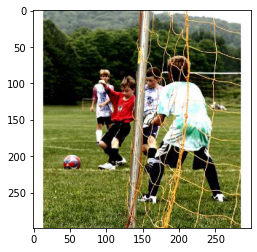

Real caption Descriptions :
_________________________
group of young boys on opposing teams are playing soccer
children playing soccer near the goal net
four boys playing soccer
four children run along grassy field playing soccer
the young boy in the red shirt is kicking soccer ball
_____________________________________
Caption: girl in blue shirt plays with pink and white ball
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.638437
Individual 2-gram: 0.397824
Individual 3-gram: 0.276972
Individual 4-gram: 0.156780
_____________________________________
Cumulative 1-gram: 0.638437
Cumulative 2-gram: 0.503970
Cumulative 3-gram: 0.416477
Cumulative 4-gram: 0.324066
**************************************************************


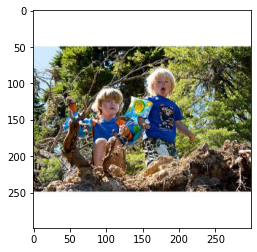

Real caption Descriptions :
_________________________
there are two kids in swimmies playing outside next to some trees
two boys with long blond hair are climbing on hillside
two boys with water wings climb tree
two children posing for picture wearing water wings and sitting on rock
two little boys are sitting on clump of dirt
_____________________________________
Caption: two young children are playing together on the edge of the
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.805014
Individual 2-gram: 0.457978
Individual 3-gram: 0.299806
Individual 4-gram: 0.165485
_____________________________________
Cumulative 1-gram: 0.805014
Cumulative 2-gram: 0.607189
Cumulative 3-gram: 0.483449
Cumulative 4-gram: 0.367758
**************************************************************


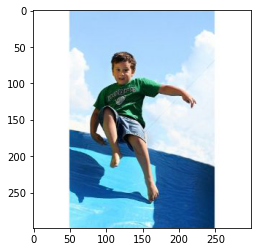

Real caption Descriptions :
_________________________
boy in green shirt above something blue
small boy getting tossed into the air
young boy jumps around on blue mat with halfsmile on his face
young boy plays in front of blue object
the boy wearing the green shirt is climbing on blue inflatable
_____________________________________
Caption: young girl in swimming trunks jumping over hurdle
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.597910
Individual 2-gram: 0.372893
Individual 3-gram: 0.261655
Individual 4-gram: 0.148896
_____________________________________
Cumulative 1-gram: 0.597910
Cumulative 2-gram: 0.472183
Cumulative 3-gram: 0.391529
Cumulative 4-gram: 0.305287
**************************************************************


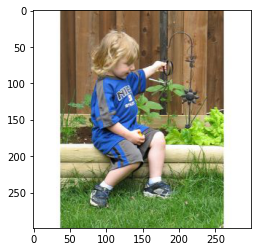

Real caption Descriptions :
_________________________
blond child is playing with metal yard ornament
child dressed in blue sits next to plants
child in blur shirt playing in flower bed
child plays outside by garden
small child is sitting playing with an adornment in small garden
_____________________________________
Caption: young child in the red flowers
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.622222
Individual 2-gram: 0.343655
Individual 3-gram: 0.241698
Individual 4-gram: 0.138131
_____________________________________
Cumulative 1-gram: 0.622222
Cumulative 2-gram: 0.462418
Cumulative 3-gram: 0.376186
Cumulative 4-gram: 0.290676
**************************************************************


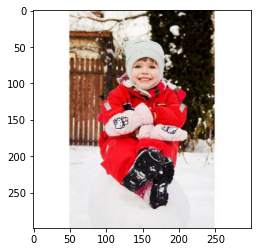

Real caption Descriptions :
_________________________
child dressed for the cold sits in the snow
child in red sits in the snow
little girl in red snowsuit sits on snowball in backyard
little kid in red snowsuit with hello kitty mittens
the small girl in the hello kitty gloves and red snowsuit smiles while sitting on large snowball
_____________________________________
Caption: two hockey players fighting on the ice
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.617194
Individual 2-gram: 0.372063
Individual 3-gram: 0.256818
Individual 4-gram: 0.145456
_____________________________________
Cumulative 1-gram: 0.617194
Cumulative 2-gram: 0.479202
Cumulative 3-gram: 0.392933
Cumulative 4-gram: 0.304333
**************************************************************


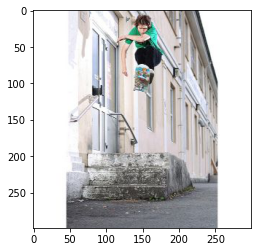

Real caption Descriptions :
_________________________
boy in black pants and green tshirt jumps high with his skateboard
guy on skateboard jumping off some steps
person in green shirt on skateboard jumping off of short set of stairs
skateboarder in green shirt is taking jump of step in front of pink building
he is in the air on his skateboard
_____________________________________
Caption: the train is down the stairs
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.638759
Individual 2-gram: 0.346257
Individual 3-gram: 0.223046
Individual 4-gram: 0.123076
_____________________________________
Cumulative 1-gram: 0.638759
Cumulative 2-gram: 0.470292
Cumulative 3-gram: 0.369836
Cumulative 4-gram: 0.279143
**************************************************************


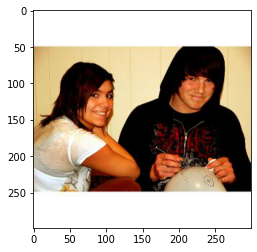

Real caption Descriptions :
_________________________
boy pauses in drawing on white balloon to smile at the camera and the girl next to him also smiles at the camera
brunette boy and girl smile for the camera while drawing faces on white balloon
girl is smiling and young man is drawing on white balloon
two smiling people with dark hair
two young adults smile at the camera
_____________________________________
Caption: man and woman and woman sitting in the laughing
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.731392
Individual 2-gram: 0.423522
Individual 3-gram: 0.282320
Individual 4-gram: 0.157291
_____________________________________
Cumulative 1-gram: 0.731392
Cumulative 2-gram: 0.556561
Cumulative 3-gram: 0.447490
Cumulative 4-gram: 0.342466
**************************************************************


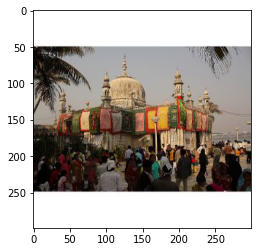

Real caption Descriptions :
_________________________
crowd scene in front of mosque
large group is shown in the street
lot of people are gathered around mosquelike building
busy marketplace in an arabian country
there are lot of people in front of tan building with colorful squares hanging from the top
_____________________________________
Caption: crowd of people parade at an outdoor event
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.714286
Individual 2-gram: 0.361395
Individual 3-gram: 0.257822
Individual 4-gram: 0.147618
_____________________________________
Cumulative 1-gram: 0.714286
Cumulative 2-gram: 0.508074
Cumulative 3-gram: 0.408929
Cumulative 4-gram: 0.314832
**************************************************************


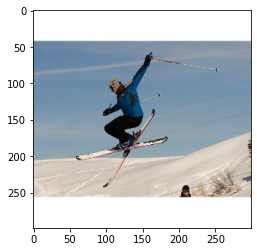

Real caption Descriptions :
_________________________
skier is airborne with his skis crossed
skier performs jumping trick on the slopes
man flying through the air on skis over mountain
the man is doing jump while skiing
there is skier getting some air on the slopes
_____________________________________
Caption: two downhill in ski lift
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.000000
Individual 2-gram: 0.000000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
_____________________________________
Cumulative 1-gram: 0.000000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000
**************************************************************


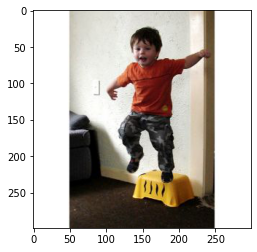

Real caption Descriptions :
_________________________
little boy is jumping up and down
young boy jumping
young child is jumping off yellow stool inside room in house
boy in orange shirt and camouflage pants jumping up
little boy with orange shirt jumps off of small yellow foot stool indoors
_____________________________________
Caption: young child in red attempts upside down
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.769841
Individual 2-gram: 0.385117
Individual 3-gram: 0.261170
Individual 4-gram: 0.146906
_____________________________________
Cumulative 1-gram: 0.769841
Cumulative 2-gram: 0.544499
Cumulative 3-gram: 0.429875
Cumulative 4-gram: 0.326580
**************************************************************


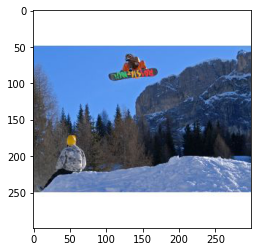

Real caption Descriptions :
_________________________
guy is watching another guy jump in the air while snowboarding
person in orange pants is doing tricks on snowboard while person in yellow cap watches
person sits on snowbank watching snowboarder take high leap
person watches as snowboarder does fancy trick in the air
snowboarder performing trick high in the air in snowy area
_____________________________________
Caption: the snowboarder is performing trick on the snow
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.777438
Individual 2-gram: 0.367957
Individual 3-gram: 0.243870
Individual 4-gram: 0.135720
_____________________________________
Cumulative 1-gram: 0.777438
Cumulative 2-gram: 0.534849
Cumulative 3-gram: 0.414813
Cumulative 4-gram: 0.311936
**************************************************************


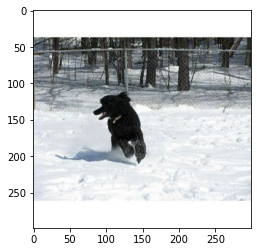

Real caption Descriptions :
_________________________
black dog runs through the snow
black poodle frolics in the snow
black poodle is running in the snow
black poodle plays in the snow
black standard poodle running through the snow in fencedin yard
_____________________________________
Caption: black dog is chasing black dog toy in the snow
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.844444
Individual 2-gram: 0.434259
Individual 3-gram: 0.250876
Individual 4-gram: 0.148081
_____________________________________
Cumulative 1-gram: 0.844444
Cumulative 2-gram: 0.605564
Cumulative 3-gram: 0.455037
Cumulative 4-gram: 0.341641
**************************************************************


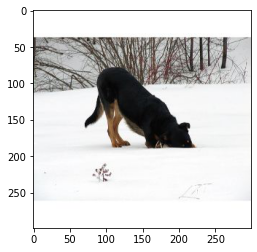

Real caption Descriptions :
_________________________
black and brown dog digging through the snow
black dog is digging in the snow
black dog is digging in the snow
dog is rubbing its face in the snow
large black dog rubs its face in the snow
_____________________________________
Caption: black dog carries green toy in the snow
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.892857
Individual 2-gram: 0.496032
Individual 3-gram: 0.282577
Individual 4-gram: 0.155869
_____________________________________
Cumulative 1-gram: 0.892857
Cumulative 2-gram: 0.665496
Cumulative 3-gram: 0.503676
Cumulative 4-gram: 0.373721
**************************************************************


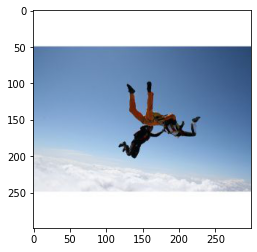

Real caption Descriptions :
_________________________
three person sky dive team in the air performing stunt
three people wearing parachutes are freefalling together through the sky
three skydivers are in formation above the clouds
trio of skydivers holding hands in sky
two people are parachuting over white clouds
_____________________________________
Caption: woman is throwing another man upside on the
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.514577
Individual 2-gram: 0.345116
Individual 3-gram: 0.252396
Individual 4-gram: 0.145809
_____________________________________
Cumulative 1-gram: 0.514577
Cumulative 2-gram: 0.421412
Cumulative 3-gram: 0.358917
Cumulative 4-gram: 0.284329
**************************************************************


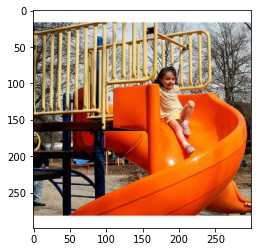

Real caption Descriptions :
_________________________
small girl in yellow slides down an orange slide
young girl dressed in yellow sliding down curvy red slide at playground
young girl on an orange slide
young girl sliding down an orange slide
little girl sliding down an orange playground slide
_____________________________________
Caption: startseq blonde girl sliding down slide
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.911111
Individual 2-gram: 0.520370
Individual 3-gram: 0.314355
Individual 4-gram: 0.162350
_____________________________________
Cumulative 1-gram: 0.911111
Cumulative 2-gram: 0.688560
Cumulative 3-gram: 0.533569
Cumulative 4-gram: 0.394402
**************************************************************


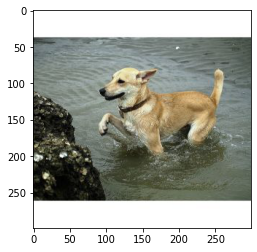

Real caption Descriptions :
_________________________
brown dog wades through water and walks toward rock
dog has waded through shallow water to reach rock outcropping
light brown dog is splashing in the water with its paw
small brown dog is about ready to exit the water after swim
yellow dog in shallow water
_____________________________________
Caption: brown dog is playing in the water
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 1.126984
Individual 2-gram: 0.731217
Individual 3-gram: 0.436922
Individual 4-gram: 0.205491
_____________________________________
Cumulative 1-gram: 1.126984
Cumulative 2-gram: 0.907783
Cumulative 3-gram: 0.713841
Cumulative 4-gram: 0.521543
**************************************************************


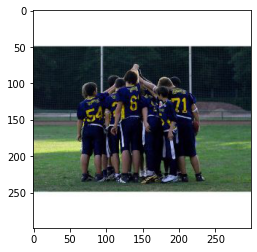

Real caption Descriptions :
_________________________
group of children wearing blue and yellow uniforms put their hangs together
soccer team with blue jerseys is huddled together with their hands touching above their heads
young flag football team are huddled together
boys huddle during soccer game
soccer players in blue before game
_____________________________________
Caption: several football players are in teams poses together on different team
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.735059
Individual 2-gram: 0.418180
Individual 3-gram: 0.273753
Individual 4-gram: 0.151105
_____________________________________
Cumulative 1-gram: 0.735059
Cumulative 2-gram: 0.554425
Cumulative 3-gram: 0.441438
Cumulative 4-gram: 0.335800
**************************************************************


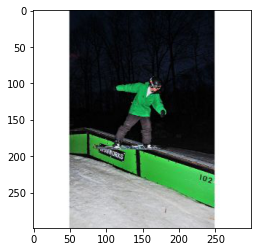

Real caption Descriptions :
_________________________
helmeted boy flies through the air on snowboard
snowboarder balancing on wall
snowboarder in green grinds along the edge of rail at night
snowboarder wearing green jacket jumping green rainling
snowboarder wearing green jacket jumps above low gate
_____________________________________
Caption: man in yellow and red pants is grinding on skateboard
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.517359
Individual 2-gram: 0.339858
Individual 3-gram: 0.243912
Individual 4-gram: 0.139626
_____________________________________
Cumulative 1-gram: 0.517359
Cumulative 2-gram: 0.419320
Cumulative 3-gram: 0.353372
Cumulative 4-gram: 0.278178
**************************************************************


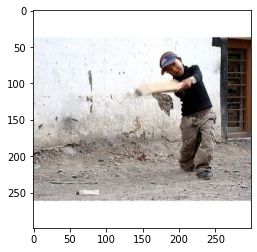

Real caption Descriptions :
_________________________
boy in dusty alley playing stickball
boy swings piece of wood
child swings bat next to stone wall
young boy wearing blue visor swings bat
young boy with visor on plays ball with his bat in the street
_____________________________________
Caption: man wearing red shirt and red pants climbs up to jump
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.469061
Individual 2-gram: 0.314467
Individual 3-gram: 0.227506
Individual 4-gram: 0.130488
_____________________________________
Cumulative 1-gram: 0.469061
Cumulative 2-gram: 0.384062
Cumulative 3-gram: 0.325629
Cumulative 4-gram: 0.257242
**************************************************************


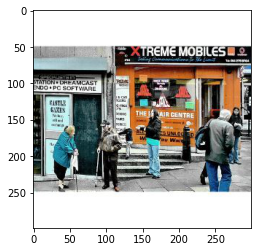

Real caption Descriptions :
_________________________
group of people are standing in front of some stores
people stand on sidewalk outside of retail stores
people walking or talking on city street
several people in front of stores
two people are talking outside of the video game shop next door to the mobile phone store
_____________________________________
Caption: three people outside outside store
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.666858
Individual 2-gram: 0.342183
Individual 3-gram: 0.212193
Individual 4-gram: 0.115422
_____________________________________
Cumulative 1-gram: 0.666858
Cumulative 2-gram: 0.477690
Cumulative 3-gram: 0.367442
Cumulative 4-gram: 0.273418
**************************************************************


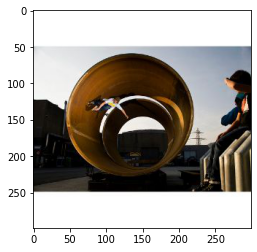

Real caption Descriptions :
_________________________
man is skating through tunnel
person skates along the inside of long tube
rollerblader rides high in full pipe while others watch
rollerblader skating inside tube
skateboarder whizzes through tunnel
_____________________________________
Caption: man in red baseball horse on the bull
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.681243
Individual 2-gram: 0.400671
Individual 3-gram: 0.270914
Individual 4-gram: 0.151982
_____________________________________
Cumulative 1-gram: 0.681243
Cumulative 2-gram: 0.522451
Cumulative 3-gram: 0.423394
Cumulative 4-gram: 0.325596
**************************************************************


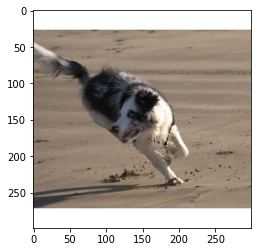

Real caption Descriptions :
_________________________
black and white dog is running on the beach
dog runs on the beach
black and white dog on wet sand
the black and white dog is running in the damp sand
this large black and white dog is running on the sand
_____________________________________
Caption: dog running on sandy beach
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.950000
Individual 2-gram: 0.465274
Individual 3-gram: 0.274950
Individual 4-gram: 0.146235
_____________________________________
Cumulative 1-gram: 0.950000
Cumulative 2-gram: 0.664839
Cumulative 3-gram: 0.498823
Cumulative 4-gram: 0.365119
**************************************************************


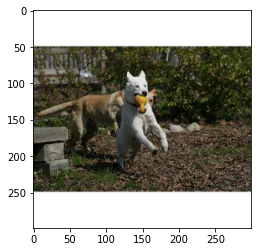

Real caption Descriptions :
_________________________
beige dog runs behind white dog holding yellow toy
dog chases another dog with toy in its mouth
dog running in park with rubber chicken in its mouth
white dog carries yellow toy while another dog follows
the dog is holding yellow toy
_____________________________________
Caption: dog chases another dog toy in the grass
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.977050
Individual 2-gram: 0.591833
Individual 3-gram: 0.354166
Individual 4-gram: 0.176888
_____________________________________
Cumulative 1-gram: 0.977050
Cumulative 2-gram: 0.760428
Cumulative 3-gram: 0.591826
Cumulative 4-gram: 0.436270
**************************************************************


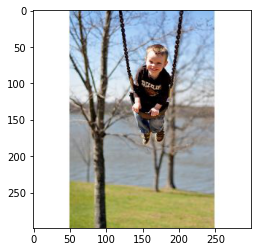

Real caption Descriptions :
_________________________
boy on swing
little boy is swinging on swing beside some trees and river
toddler swings back very high
young boy is riding swing high in the air
small child swinging on swing with trees in the background
_____________________________________
Caption: little girl in playground hat rides swing
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.712432
Individual 2-gram: 0.403809
Individual 3-gram: 0.267400
Individual 4-gram: 0.148983
_____________________________________
Cumulative 1-gram: 0.712432
Cumulative 2-gram: 0.536364
Cumulative 3-gram: 0.428950
Cumulative 4-gram: 0.327193
**************************************************************


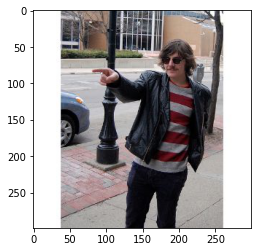

Real caption Descriptions :
_________________________
man in leather jacket and striped shirt points at something off camera
man in sunglasses red striped sweater and leather jacket smiles and points his finger
man with dark glasses black jacket and white and red horizontallystriped shirt pointing at something while standing on sidewalk
man with shaggy hair and moustache pointing down street
the man with the red and grey shirt and glasses is pointing
_____________________________________
Caption: woman in black and red boots is holding cup in her hand
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.641414
Individual 2-gram: 0.327189
Individual 3-gram: 0.258649
Individual 4-gram: 0.152721
_____________________________________
Cumulative 1-gram: 0.641414
Cumulative 2-gram: 0.458109
Cumulative 3-gram: 0.382326
Cumulative 4-gram: 0.301743
**************************************************************


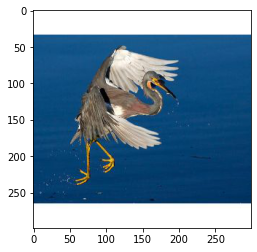

Real caption Descriptions :
_________________________
crane wings outstreached above the ocean
large bird landing on water
large gray and white bird begins to take flight
bird spreads wings over water
large dark bird over the water
_____________________________________
Caption: the large gray are into the water
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.825397
Individual 2-gram: 0.459191
Individual 3-gram: 0.285861
Individual 4-gram: 0.155137
_____________________________________
Cumulative 1-gram: 0.825397
Cumulative 2-gram: 0.615642
Cumulative 3-gram: 0.480272
Cumulative 4-gram: 0.360066
**************************************************************


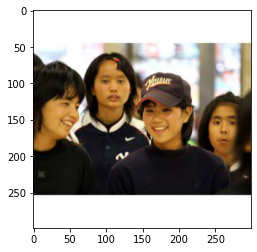

Real caption Descriptions :
_________________________
group of asian girls are standing together
group of asian women in sports attire and one woman in the center is wearing baseball cap
four teenagers in dark clothes looking in various directions
there are several asian people one wearing baseball cap
two girls laugh while other girls look on
_____________________________________
Caption: the man in the brown shirt has his arm around his ears
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.474747
Individual 2-gram: 0.271633
Individual 3-gram: 0.240131
Individual 4-gram: 0.146549
_____________________________________
Cumulative 1-gram: 0.474747
Cumulative 2-gram: 0.359106
Cumulative 3-gram: 0.317683
Cumulative 4-gram: 0.259549
**************************************************************


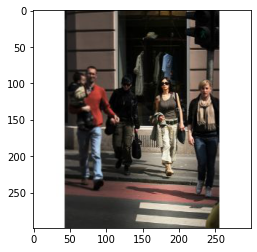

Real caption Descriptions :
_________________________
group of people are in front of store walking across crosswalk
group of people walking across street
four people and baby are crossing the street at crosswalk
four people and child walking in the street
people crossing the street
_____________________________________
Caption: startseq group of people are waiting alone on subway
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.754630
Individual 2-gram: 0.471781
Individual 3-gram: 0.308054
Individual 4-gram: 0.158240
_____________________________________
Cumulative 1-gram: 0.754630
Cumulative 2-gram: 0.596674
Cumulative 3-gram: 0.482207
Cumulative 4-gram: 0.362957
**************************************************************


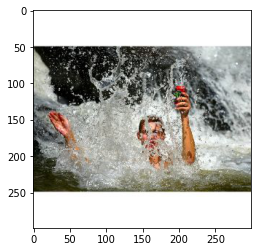

Real caption Descriptions :
_________________________
boy holding soda can in waterfall
man holding can in waterfall
man is flailing in water while holding up drink can
man with canned drink is standing under waterfall
young man splashes in the water holding canned soda
_____________________________________
Caption: woman in wetsuit hits large splash in the ocean
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.523148
Individual 2-gram: 0.294011
Individual 3-gram: 0.239150
Individual 4-gram: 0.142900
_____________________________________
Cumulative 1-gram: 0.523148
Cumulative 2-gram: 0.392188
Cumulative 3-gram: 0.336254
Cumulative 4-gram: 0.269261
**************************************************************


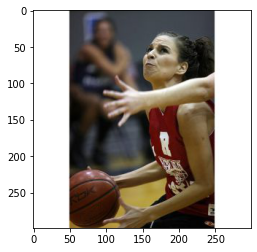

Real caption Descriptions :
_________________________
basketball player looks upward as hand reaches for her ball
female basketball player wearing red uniform is holding basketball and looking up while an arm is trying to block her
female woman has basketball in her hands and determined look on her face
woman basketball player holding the ball grimaces with effort while another player arm attempts to block her
woman with red basketball jersey is holding basketball and looking up
_____________________________________
Caption: the basketball player in blue and white basketball team dribbles the ball
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.782828
Individual 2-gram: 0.404630
Individual 3-gram: 0.284463
Individual 4-gram: 0.161326
_____________________________________
Cumulative 1-gram: 0.782828
Cumulative 2-gram: 0.562811
Cumulative 3-gram: 0.451926
Cumulative 4-gram: 0.347227
**************************************************************


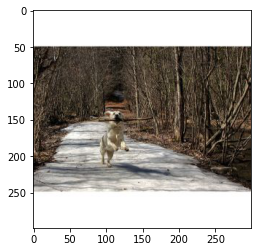

Real caption Descriptions :
_________________________
dog jumps forward carrying large stick
dog runs down trail with stick in his mouth
dog runs with large stick in its mouth
dog with stick in his mouth runs in forest
white dog running down path with long stick in his mouth
_____________________________________
Caption: two dogs run through the snow
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.000000
Individual 2-gram: 0.000000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
_____________________________________
Cumulative 1-gram: 0.000000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000
**************************************************************


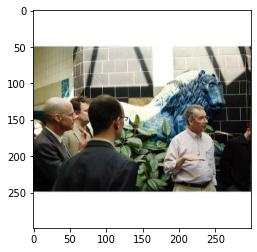

Real caption Descriptions :
_________________________
group of men in suits are standing in front of statue of lion
group of men stand talking in front of statute of blue lion
group of people in suits stand around man in pink shirt who is lecturing
man giving lecture to interested people in front of clue statue
men standing in front of statue of lion
_____________________________________
Caption: man in crowd holds sign
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.375021
Individual 2-gram: 0.206565
Individual 3-gram: 0.134635
Individual 4-gram: 0.074835
_____________________________________
Cumulative 1-gram: 0.375021
Cumulative 2-gram: 0.278327
Cumulative 3-gram: 0.220507
Cumulative 4-gram: 0.167145
**************************************************************


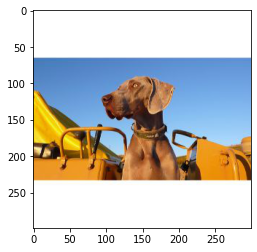

Real caption Descriptions :
_________________________
brown dog looks off into the distance by some farm equipment
dark brown dog standing on construction equipment
dog looking off into the distance
grey dog with matching collar standing beside tractor
brown dog with brown collar looking to left with clear blue sky in background
_____________________________________
Caption: brown dog with red ears standing in the middle of the camera
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.727273
Individual 2-gram: 0.336364
Individual 3-gram: 0.211960
Individual 4-gram: 0.137158
_____________________________________
Cumulative 1-gram: 0.727273
Cumulative 2-gram: 0.494599
Cumulative 3-gram: 0.376592
Cumulative 4-gram: 0.290399
**************************************************************


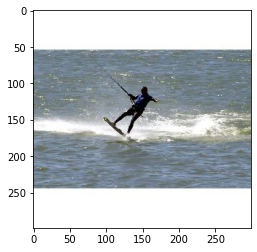

Real caption Descriptions :
_________________________
man in wetsuit is leaving the water while waterskiing
man is riding board in the ocean and is being pulled from above
man is waterskiing on one ski
man riding the water on single board holding on to support with one hand
water glider
_____________________________________
Caption: man is on boat on surfboard
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.844444
Individual 2-gram: 0.417730
Individual 3-gram: 0.266390
Individual 4-gram: 0.146362
_____________________________________
Cumulative 1-gram: 0.844444
Cumulative 2-gram: 0.593927
Cumulative 3-gram: 0.458231
Cumulative 4-gram: 0.342454
**************************************************************


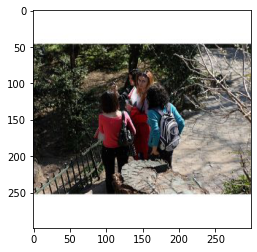

Real caption Descriptions :
_________________________
group of people standing on rock path
group of women converse together while overlooking the views of the foliage
woman looks skeptically at the person taking picture of her and girls who are outdoors
four women stop along walkway to look at an area beyond the fence
women are outside
_____________________________________
Caption: two people sitting on stone wall
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.544705
Individual 2-gram: 0.314906
Individual 3-gram: 0.212596
Individual 4-gram: 0.119593
_____________________________________
Cumulative 1-gram: 0.544705
Cumulative 2-gram: 0.414163
Cumulative 3-gram: 0.334736
Cumulative 4-gram: 0.256981
**************************************************************


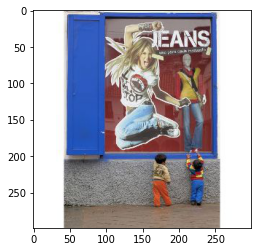

Real caption Descriptions :
_________________________
the two kids are looking at sign
two children looking up at large fashion advertisement on concrete wall
two little boys admire shop window
two small children standing next to jeans advertisement
two small children stand next to window display
_____________________________________
Caption: the woman is playing with two children stand in front of wall
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.671717
Individual 2-gram: 0.367593
Individual 3-gram: 0.272117
Individual 4-gram: 0.157211
_____________________________________
Cumulative 1-gram: 0.671717
Cumulative 2-gram: 0.496909
Cumulative 3-gram: 0.410215
Cumulative 4-gram: 0.320588
**************************************************************


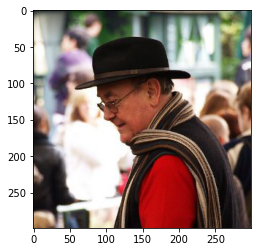

Real caption Descriptions :
_________________________
man is wearing black hat and brown scarf in city street
man wearing bowler cap and scarf
man wearing hat and scarf stands in crowd
man wearing hat is standing in crowd of people
the old man is wearing glasses scarf and hat
_____________________________________
Caption: man in yellow jacket wears black bandanna
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.712432
Individual 2-gram: 0.403809
Individual 3-gram: 0.267400
Individual 4-gram: 0.148983
_____________________________________
Cumulative 1-gram: 0.712432
Cumulative 2-gram: 0.536364
Cumulative 3-gram: 0.428950
Cumulative 4-gram: 0.327193
**************************************************************


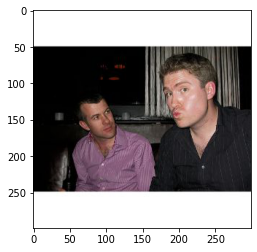

Real caption Descriptions :
_________________________
man in purple shirt is looking at man in black shirt who is pulling funny face
man in purple shirt looking at man in black shirt making silly face
man watching another man do kissing pose
man making kissing face for the camera while another man looks on
two men sit together and one looks at the other while he makes funny face
_____________________________________
Caption: man with beer looking at the woman in the stands
_____________________________________
BLEU SCORES@K=1,2,3,4
Individual 1-gram: 0.606467
Individual 2-gram: 0.328225
Individual 3-gram: 0.227604
Individual 4-gram: 0.128640
_____________________________________
Cumulative 1-gram: 0.606467
Cumulative 2-gram: 0.446159
Cumulative 3-gram: 0.359471
Cumulative 4-gram: 0.276302
**************************************************************
**************************************************************
The average Individual 1-gram 0.6478343649771773
The average Individual 2-

In [ ]:
test_path = os.path.join(root_captioning,'model_file',f'test{OUTPUT_DIM}.pkl')
start = time()
with open(test_path, "rb") as fp:
  encoding_test = pickle.load(fp)

Ibleu_1=[]
Ibleu_2=[]
Ibleu_3=[]
Ibleu_4=[]
Cbleu_1=[]
Cbleu_2=[]
Cbleu_3=[]
Cbleu_4=[]

for z in range(100):
  pic = list(encoding_test.keys())[z]
  image = encoding_test[pic].reshape((1,OUTPUT_DIM))
 
  x=plt.imread(os.path.join(root_captioning,'Images_Dataset_resized', pic))
  plt.imshow(x)
  plt.show()

  print("Real caption Descriptions :")
  print("_________________________")
  test_des=pickle.load(open("test_des.pickle","rb"))

  Real_caption=test_des[Path(pic).stem]
  
  l = []
  for line in Real_caption:
    l.append(line.split(','))

  words=[]
  for a in Real_caption:
    words.append(a.split())

  caption=generateCaption(image)
  new_caption=caption.split()
 
  for e, y, z,a,b in zip(*l): 
    print(e) 
    print(y)
    print(z)
    print(a)
    print(b)
 
  
  print("_____________________________________")
  print("Caption:",generateCaption(image))
  print("_____________________________________")
  smoothie = SmoothingFunction().method7

  Ibleu1=sentence_bleu(words, new_caption,smoothing_function=smoothie, weights=(1, 0, 0, 0))
  Ibleu2=sentence_bleu(words, new_caption,smoothing_function=smoothie, weights=(0, 1, 0, 0))
  Ibleu3=sentence_bleu(words, new_caption, smoothing_function=smoothie,weights=(0, 0, 1, 0))
  Ibleu4=sentence_bleu(words, new_caption, smoothing_function=smoothie,weights=(0, 0, 0, 1))

  Cbleu1=sentence_bleu(words, new_caption,smoothing_function=smoothie, weights=(1, 0, 0, 0))
  Cbleu2=sentence_bleu(words, new_caption,smoothing_function=smoothie, weights=(0.5,0.5, 0, 0))
  Cbleu3=sentence_bleu(words, new_caption, smoothing_function=smoothie,weights=(0.33, 0.33, 0.33, 0))
  Cbleu4=sentence_bleu(words, new_caption, smoothing_function=smoothie,weights=(0.25, 0.25, 0.25, 0.25))
  Ibleu_1.append(Ibleu1)
  Ibleu_2.append(Ibleu2)
  Ibleu_3.append(Ibleu3)
  Ibleu_4.append(Ibleu4)
  
  Cbleu_1.append(Cbleu1)
  Cbleu_2.append(Cbleu2)
  Cbleu_3.append(Cbleu3)
  Cbleu_4.append(Cbleu4)



  print("BLEU SCORES@K=1,2,3,4")
  # n-gram individual BLEU

  print('Individual 1-gram: %f' % sentence_bleu(words, new_caption,smoothing_function=smoothie, weights=(1, 0, 0, 0)))
  print('Individual 2-gram: %f' % sentence_bleu(words, new_caption,smoothing_function=smoothie, weights=(0, 1, 0, 0)))
  print('Individual 3-gram: %f' % sentence_bleu(words, new_caption, smoothing_function=smoothie,weights=(0, 0, 1, 0)))
  print('Individual 4-gram: %f' % sentence_bleu(words, new_caption, smoothing_function=smoothie,weights=(0, 0, 0, 1)))
  print("_____________________________________")
  # cumulative BLEU scores
  print('Cumulative 1-gram: %f' % sentence_bleu(words, new_caption,smoothing_function=smoothie, weights=(1, 0, 0, 0)))
  print('Cumulative 2-gram: %f' % sentence_bleu(words, new_caption,smoothing_function=smoothie, weights=(0.5, 0.5, 0, 0)))
  print('Cumulative 3-gram: %f' % sentence_bleu(words, new_caption,smoothing_function=smoothie, weights=(0.33, 0.33, 0.33, 0)))
  print('Cumulative 4-gram: %f' % sentence_bleu(words, new_caption, smoothing_function=smoothie ,weights=(0.25, 0.25, 0.25, 0.25)))

  
  print("**************************************************************")
 

print("**************************************************************")

def cal_average(num):
  sum_num = 0
  for t in num:
    sum_num = sum_num + t
    avg = (sum_num / len(num))
  return avg
print("The average Individual 1-gram", cal_average(Ibleu_1))
print("The average Individual 2-gram", cal_average(Ibleu_2))
print("The average Individual 3-gram", cal_average(Ibleu_3))
print("The average Individual 4-gram", cal_average(Ibleu_4))
print("_____________________________________")
print("The average Cumulative 1-gram", cal_average(Cbleu_1))
print("The average Cumulative 2-gram", cal_average(Cbleu_2))
print("The average Cumulative 3-gram", cal_average(Cbleu_3))
print("The average Cumulative 4-gram", cal_average(Cbleu_4))

  
  

# Done!
It can be noticed that Model having LSTM as decoder out performed the model with Simple RNN.